In [1]:
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
import os
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
# functions 
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files


def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    for t in range(n_trials):
        
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)


def find_candidate_states(indata, n_classes, temporal_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > (1 / n_classes) * 2)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array


def save_data_to_h5(directory, filename, datasets, dataset_names):
    """
    Saves multiple datasets to an HDF5 file, overwriting existing datasets.

    Args:
        directory (str): The directory where the file should be saved.
        filename (str): The name of the HDF5 file.
        datasets (list): A list of datasets to save.
        dataset_names (list): A list of names to assign to the datasets.
    """

    full_path = os.path.join(directory, filename)

    with h5py.File(full_path, 'a') as f:  # Open in append mode
        for dataset, dataset_name in zip(datasets, dataset_names):
            try:
                del f[dataset_name]  # Attempt to delete existing dataset
            except KeyError:
                pass  # Ignore if dataset doesn't exist
            f.create_dataset(dataset_name, data=dataset)  # Recreate dataset
            
            
def calculate_mean_and_sem(data):
    """
    Calculate mean and SEM for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array

    Returns:
    - means: 1D numpy array containing means for each column
    - sems: 1D numpy array containing SEMs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    nanstd_result = np.nanstd(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    sems = nanstd_result / np.sqrt(n_valid_values)
    
    return nanmean_result, sems

def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


In [3]:
# where are the data?
data_dir = 'C:/Users/thome/Documents/PYTHON/Self-Control/decoder_output3/King/'

# get their relevant paths
data_files = find_h5_files(data_dir)

In [4]:
# initialize variables to accumulate data into
bhv = pd.DataFrame()

OFC_ch = []
OFC_unch = []
OFC_alt_ch = []
OFC_alt_unch = []

OFC_ch_states = []
OFC_unch_states = []
OFC_alt_ch_states = []
OFC_alt_unch_states = []

CdN_ch_states = []
CdN_unch_states = []
CdN_alt_ch_states = []
CdN_alt_unch_states = []

OFC_pps = []
CdN_pps = []

In [5]:
# accumulate data from each file

for this_file in data_files:
    
    # get behavior first
    bhv_data = pd.read_hdf(this_file, key='bhv')
    
    # Append the data to the accumulated dataframe
    bhv = pd.concat([bhv, bhv_data], ignore_index=True)

    OFC_ch_states.append(pull_from_h5(this_file, 'OFC_sx_ch_states'))
    OFC_unch_states.append(pull_from_h5(this_file, 'OFC_sx_unch_states'))
    OFC_alt_ch_states.append(pull_from_h5(this_file, 'OFC_alt_ch_states'))
    OFC_alt_unch_states.append(pull_from_h5(this_file, 'OFC_alt_unch_states'))
    
    OFC_pps.append(pull_from_h5(this_file, 'all_OFC_pp'))
    
    CdN_ch_states.append(pull_from_h5(this_file, 'CdN_sx_ch_states'))
    CdN_unch_states.append(pull_from_h5(this_file, 'CdN_sx_unch_states'))
    CdN_alt_ch_states.append(pull_from_h5(this_file, 'CdN_alt_ch_states'))
    CdN_alt_unch_states.append(pull_from_h5(this_file, 'CdN_alt_unch_states'))
    
    CdN_pps.append(pull_from_h5(this_file, 'all_CdN_pp'))

    

ts = pull_from_h5(this_file, 'ts')

OFC_ch_states = np.concatenate(OFC_ch_states, axis=0)
OFC_unch_states = np.concatenate(OFC_unch_states, axis=0)
OFC_alt_ch_states = np.concatenate(OFC_alt_ch_states, axis=0)
OFC_alt_unch_states = np.concatenate(OFC_alt_unch_states, axis=0)

OFC_pps = np.concatenate(OFC_pps, axis=0)

CdN_ch_states = np.concatenate(CdN_ch_states, axis=0)
CdN_unch_states = np.concatenate(CdN_unch_states, axis=0)
CdN_alt_ch_states = np.concatenate(CdN_alt_ch_states, axis=0)
CdN_alt_unch_states = np.concatenate(CdN_alt_unch_states, axis=0)

CdN_pps = np.concatenate(CdN_pps, axis=0)


In [6]:
ix1 = (bhv['n_sacc'] == 1) 
ix2 = (bhv['n_sacc'] == 2) 
s12_ix = bhv['state'] < 3
s3_ix = bhv['state'] == 3
CdN_ix = ((np.sum(CdN_alt_unch_states[:, 41:60], axis=1) > 0) | (np.sum(CdN_ch_states[:, 41:60], axis=1) > 0) | 
         (np.sum(CdN_unch_states[:, 41:60], axis=1) > 0) | (np.sum(CdN_alt_unch_states[:, 41:60], axis=1) > 0) )

OFC_ix = ((np.sum(OFC_alt_unch_states[:, 41:60], axis=1) > 0) | (np.sum(OFC_ch_states[:, 41:60], axis=1) > 0) | 
         (np.sum(OFC_unch_states[:, 41:60], axis=1) > 0) | (np.sum(OFC_alt_unch_states[:, 41:60], axis=1) > 0) )

both_ix = CdN_ix | OFC_ix

In [7]:
# get means and SEMS
s1_OFC_ch_mean, s1_OFC_ch_sem = calculate_mean_and_interval(OFC_ch_states[ix1 & s12_ix & both_ix, :],'bootstrap')
s1_OFC_unch_mean, s1_OFC_unch_sem = calculate_mean_and_interval(OFC_unch_states[ix1 & s12_ix & both_ix, :],'bootstrap')
s1_OFC_alt_ch_mean, s1_OFC_alt_ch_sem = calculate_mean_and_interval(OFC_alt_ch_states[ix1 & s12_ix & both_ix, :],'bootstrap')
s1_OFC_alt_unch_mean, s1_OFC_alt_unch_sem = calculate_mean_and_interval(OFC_alt_unch_states[ix1 & s12_ix & both_ix, :],'bootstrap')

s2_OFC_ch_mean, s2_OFC_ch_sem = calculate_mean_and_interval(OFC_ch_states[ix2 & s12_ix & both_ix, :],'bootstrap')
s2_OFC_unch_mean, s2_OFC_unch_sem = calculate_mean_and_interval(OFC_unch_states[ix2 & s12_ix & both_ix, :],'bootstrap')
s2_OFC_alt_ch_mean, s2_OFC_alt_ch_sem = calculate_mean_and_interval(OFC_alt_ch_states[ix2 & s12_ix & both_ix, :],'bootstrap')
s2_OFC_alt_unch_mean, s2_OFC_alt_unch_sem = calculate_mean_and_interval(OFC_alt_unch_states[ix2 & s12_ix & both_ix, :],'bootstrap')

s1_CdN_ch_mean, s1_CdN_ch_sem = calculate_mean_and_interval(CdN_ch_states[ix1 & s12_ix & both_ix, :],'bootstrap')
s1_CdN_unch_mean, s1_CdN_unch_sem = calculate_mean_and_interval(CdN_unch_states[ix1 & s12_ix & both_ix, :],'bootstrap')
s1_CdN_alt_ch_mean, s1_CdN_alt_ch_sem = calculate_mean_and_interval(CdN_alt_ch_states[ix1 & s12_ix & both_ix, :],'bootstrap')
s1_CdN_alt_unch_mean, s1_CdN_alt_unch_sem = calculate_mean_and_interval(CdN_alt_unch_states[ix1 & s12_ix & both_ix, :],'bootstrap')

s2_CdN_ch_mean, s2_CdN_ch_sem = calculate_mean_and_interval(CdN_ch_states[ix2 & s12_ix & both_ix, :],'bootstrap')
s2_CdN_unch_mean, s2_CdN_unch_sem = calculate_mean_and_interval(CdN_unch_states[ix2 & s12_ix & both_ix, :],'bootstrap')
s2_CdN_alt_ch_mean, s2_CdN_alt_ch_sem = calculate_mean_and_interval(CdN_alt_ch_states[ix2 & s12_ix & both_ix, :],'bootstrap')
s2_CdN_alt_unch_mean, s2_CdN_alt_unch_sem = calculate_mean_and_interval(CdN_alt_unch_states[ix2 & s12_ix & both_ix, :],'bootstrap')


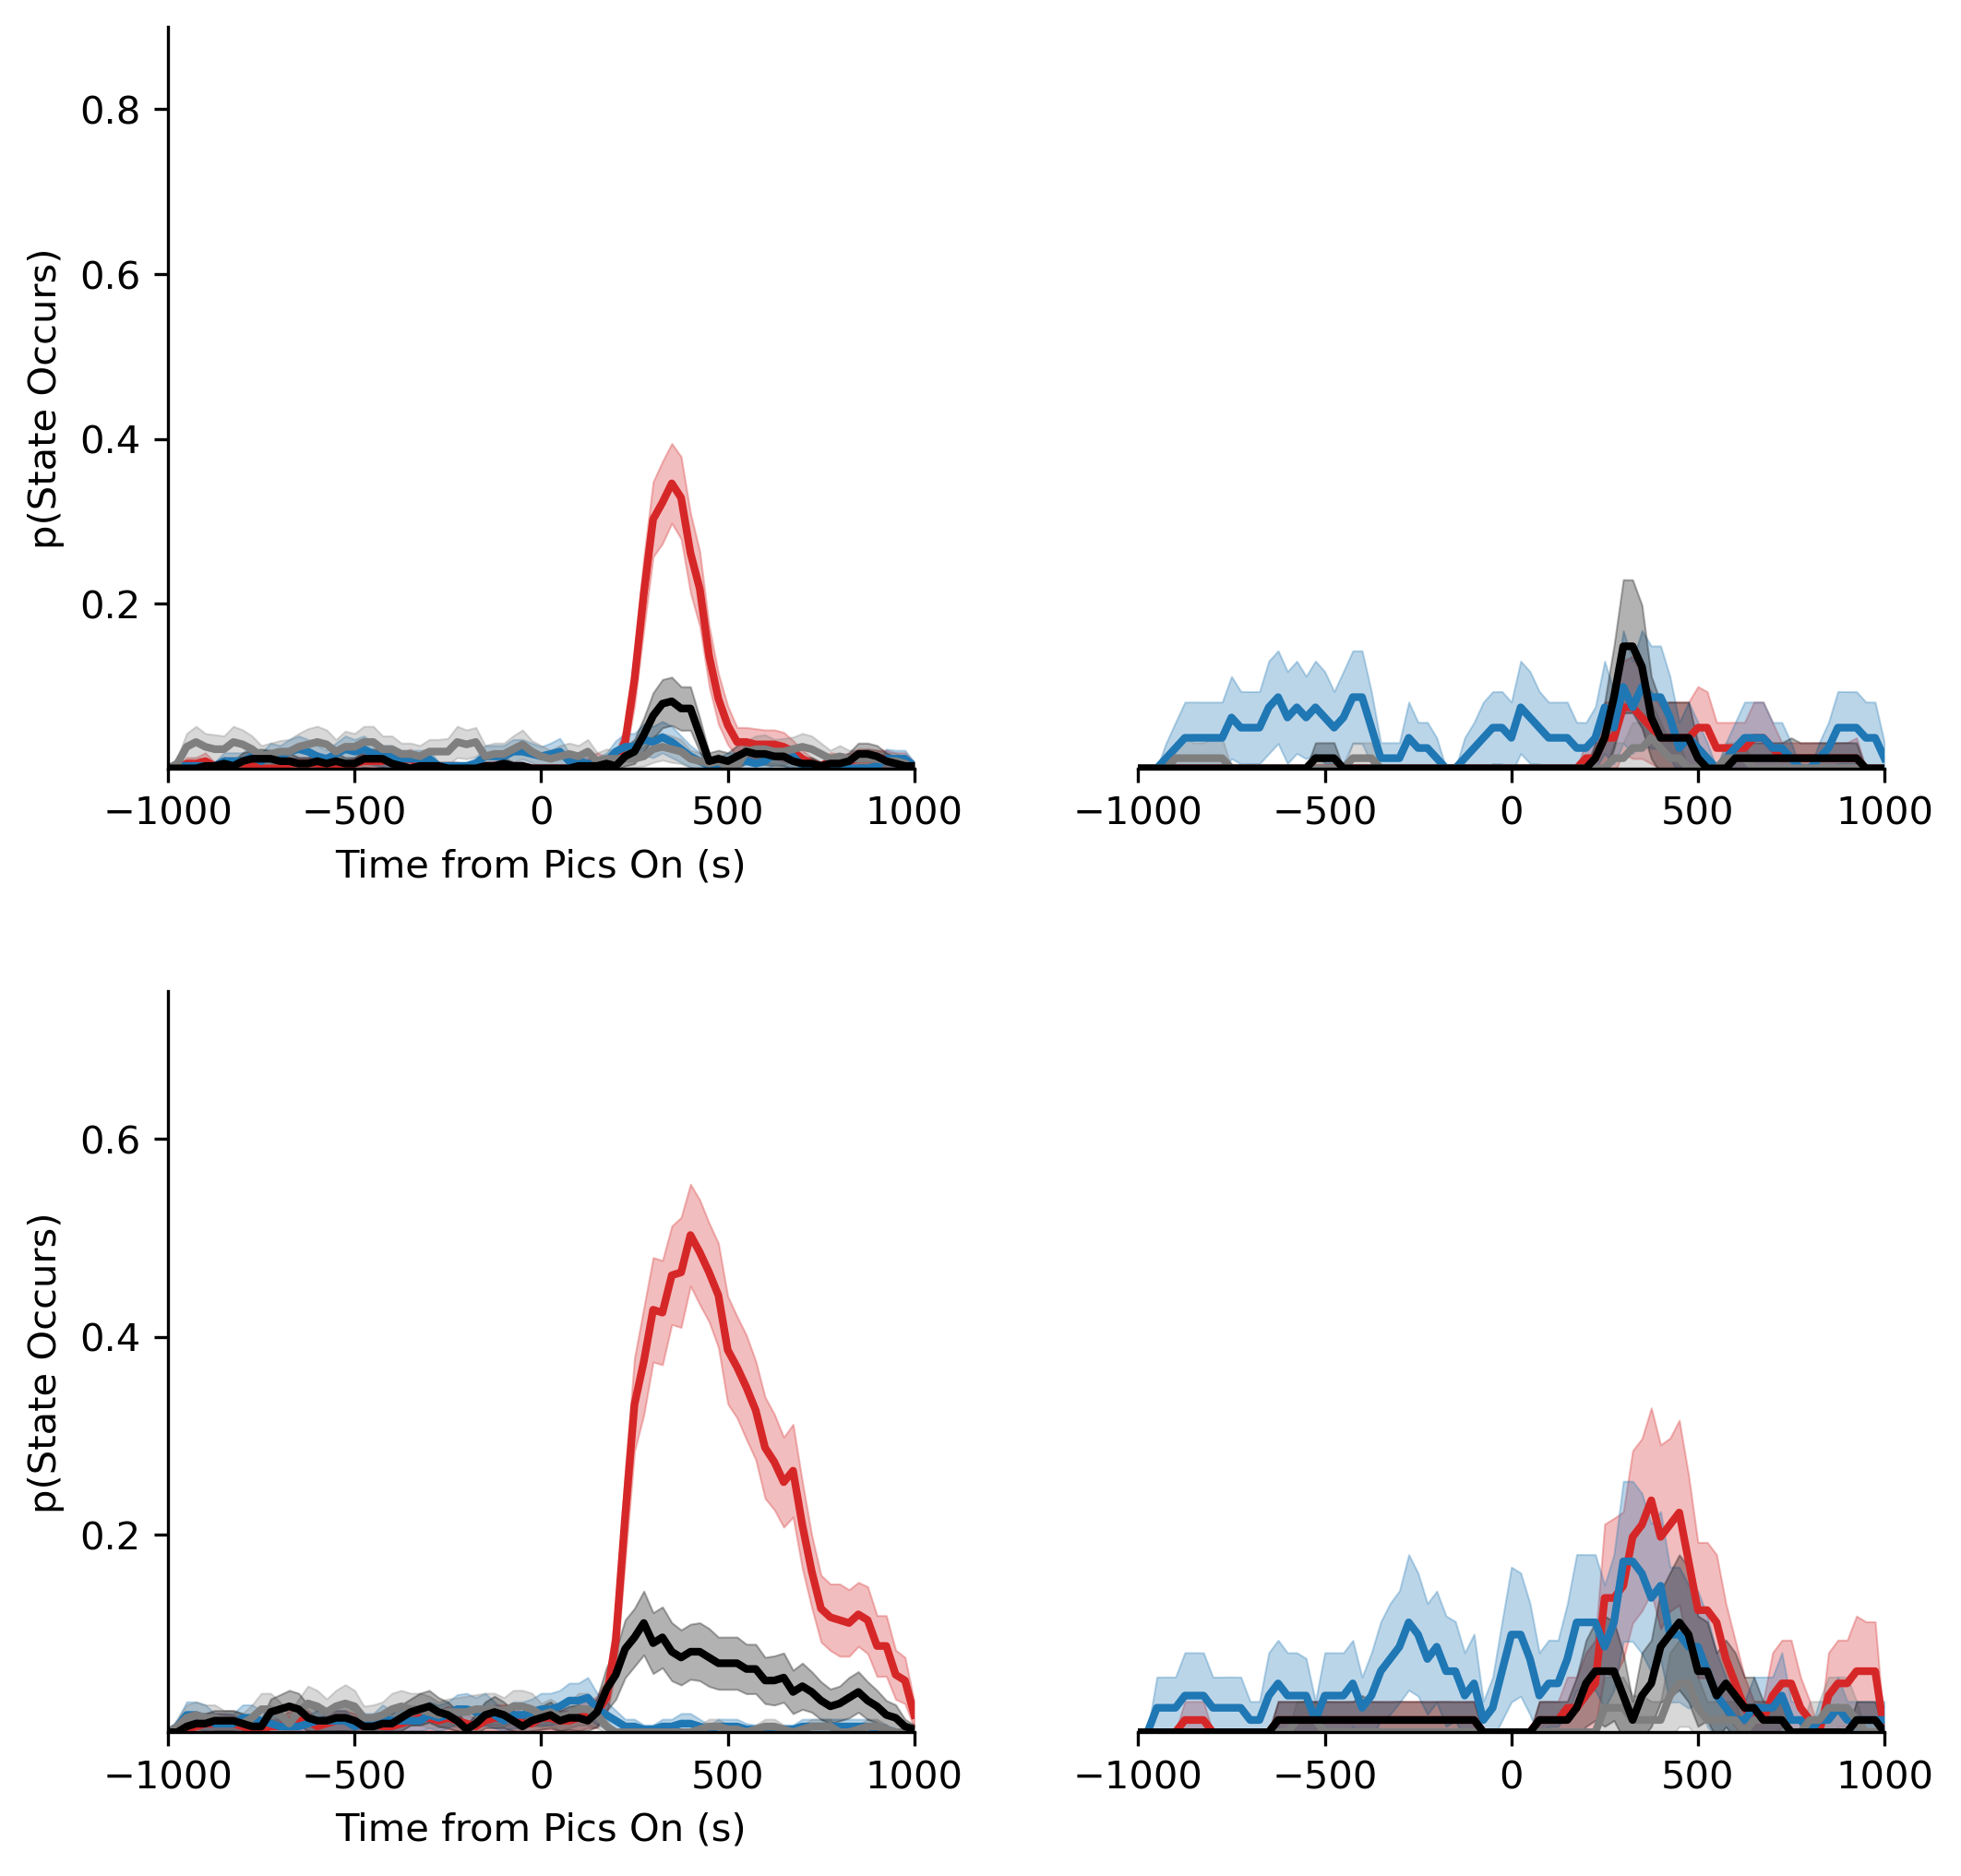

In [8]:
# plot mean and CIs of state likelihoods
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=300)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase the width and height spaces between subplots
lw = 2
ofc_ylim=(0, .9)
cdn_ylim=(0, .75)
xlim=(-1000, 1000)
a_level = .3
error_lw = .5

ax[0,0].plot(ts, s1_OFC_ch_mean, color='tab:red', linewidth=lw)
ax[0,0].fill_between(ts, s1_OFC_ch_mean-s1_OFC_ch_sem, s1_OFC_ch_mean+s1_OFC_ch_sem, color='tab:red', alpha=a_level, linewidth=error_lw)
ax[0,0].plot(ts, s1_OFC_unch_mean, color='tab:blue', linewidth=lw)
ax[0,0].fill_between(ts, s1_OFC_unch_mean-s1_OFC_unch_sem, s1_OFC_unch_mean+s1_OFC_unch_sem, color='tab:blue', alpha=a_level, linewidth=error_lw)
ax[0,0].plot(ts, s1_OFC_alt_ch_mean, color='tab:gray', linewidth=lw)
ax[0,0].fill_between(ts, s1_OFC_alt_ch_mean-s1_OFC_alt_ch_sem, s1_OFC_alt_ch_mean+s1_OFC_alt_ch_sem, color='tab:gray', alpha=a_level, linewidth=error_lw)
ax[0,0].plot(ts, s1_OFC_alt_unch_mean, color='black', linewidth=lw)
ax[0,0].fill_between(ts, s1_OFC_alt_unch_mean-s1_OFC_alt_unch_sem, s1_OFC_alt_unch_mean+s1_OFC_alt_unch_sem, color='black', alpha=a_level, linewidth=error_lw)
ax[0,0].set_ylim(ofc_ylim)
ax[0,0].set_xlim(xlim)
ax[0,0].set_yticks((.2, .4, .6, .8))
ax[0,0].set_xticks((-1000, -500, 0, 500, 1000))
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].tick_params(axis='both', which='both', top=False, right=False)
ax[0,0].set_ylabel('p(State Occurs)')
ax[0,0].set_xlabel('Time from Pics On (s)')


ax[0,1].plot(ts, s2_OFC_ch_mean, color='tab:red', linewidth=lw)
ax[0,1].fill_between(ts, s2_OFC_ch_mean-s2_OFC_ch_sem, s2_OFC_ch_mean+s2_OFC_ch_sem, color='tab:red', alpha=a_level, linewidth=error_lw)
ax[0,1].plot(ts, s2_OFC_unch_mean, color='tab:blue', linewidth=lw)
ax[0,1].fill_between(ts, s2_OFC_unch_mean-s2_OFC_unch_sem, s2_OFC_unch_mean+s2_OFC_unch_sem, color='tab:blue', alpha=a_level, linewidth=error_lw)
ax[0,1].plot(ts, s2_OFC_alt_ch_mean, color='tab:gray', linewidth=lw)
ax[0,1].fill_between(ts, s2_OFC_alt_ch_mean-s2_OFC_alt_ch_sem, s2_OFC_alt_ch_mean+s2_OFC_alt_ch_sem, color='tab:gray', alpha=a_level, linewidth=error_lw)
ax[0,1].plot(ts, s2_OFC_alt_unch_mean, color='black', linewidth=lw)
ax[0,1].fill_between(ts, s2_OFC_alt_unch_mean-s2_OFC_alt_unch_sem, s2_OFC_alt_unch_mean+s2_OFC_alt_unch_sem, color='black', alpha=a_level, linewidth=error_lw)
ax[0,1].set_ylim(ofc_ylim)
ax[0,1].set_xlim(xlim)
ax[0,1].set_yticks((.2, .4, .6, .8))
ax[0,1].set_xticks((-1000, -500, 0, 500, 1000))
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)

ax[1,0].plot(ts, s1_CdN_ch_mean, color='tab:red', linewidth=lw)
ax[1,0].fill_between(ts, s1_CdN_ch_mean-s1_CdN_ch_sem, s1_CdN_ch_mean+s1_CdN_ch_sem, color='tab:red', alpha=a_level, linewidth=error_lw)
ax[1,0].plot(ts, s1_CdN_unch_mean, color='tab:blue', linewidth=lw)
ax[1,0].fill_between(ts, s1_CdN_unch_mean-s1_CdN_unch_sem, s1_CdN_unch_mean+s1_CdN_unch_sem, color='tab:blue', alpha=a_level, linewidth=error_lw)
ax[1,0].plot(ts, s1_CdN_alt_ch_mean, color='tab:gray', linewidth=lw)
ax[1,0].fill_between(ts, s1_CdN_alt_ch_mean-s1_CdN_alt_ch_sem, s1_CdN_alt_ch_mean+s1_CdN_alt_ch_sem, color='tab:gray', alpha=a_level, linewidth=error_lw)
ax[1,0].plot(ts, s1_CdN_alt_unch_mean, color='black', linewidth=lw)
ax[1,0].fill_between(ts, s1_CdN_alt_unch_mean-s1_CdN_alt_unch_sem, s1_CdN_alt_unch_mean+s1_CdN_alt_unch_sem, color='black', alpha=a_level, linewidth=error_lw)
ax[1,0].set_ylim(cdn_ylim)
ax[1,0].set_xlim(xlim)
ax[1,0].set_yticks((.2, .4, .6))
ax[1,0].set_xticks((-1000, -500, 0, 500, 1000))
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].tick_params(axis='both', which='both', top=False, right=False)
ax[1,0].set_ylabel('p(State Occurs)')
ax[1,0].set_xlabel('Time from Pics On (s)')


ax[1,1].plot(ts, s2_CdN_ch_mean, color='tab:red', linewidth=lw)
ax[1,1].fill_between(ts, s2_CdN_ch_mean-s2_CdN_ch_sem, s2_CdN_ch_mean+s2_CdN_ch_sem, color='tab:red', alpha=a_level, linewidth=error_lw)
ax[1,1].plot(ts, s2_CdN_unch_mean, color='tab:blue', linewidth=lw)
ax[1,1].fill_between(ts, s2_CdN_unch_mean-s2_CdN_unch_sem, s2_CdN_unch_mean+s2_CdN_unch_sem, color='tab:blue', alpha=a_level, linewidth=error_lw)
ax[1,1].plot(ts, s2_CdN_alt_ch_mean, color='tab:gray', linewidth=lw)
ax[1,1].fill_between(ts, s2_CdN_alt_ch_mean-s2_CdN_alt_ch_sem, s2_CdN_alt_ch_mean+s2_CdN_alt_ch_sem, color='tab:gray', alpha=a_level, linewidth=error_lw)
ax[1,1].plot(ts, s2_CdN_alt_unch_mean, color='black', linewidth=lw)
ax[1,1].fill_between(ts, s2_CdN_alt_unch_mean-s2_CdN_alt_unch_sem, s2_CdN_alt_unch_mean+s2_CdN_alt_unch_sem, color='black', alpha=a_level, linewidth=error_lw)
ax[1,1].set_ylim(cdn_ylim)
ax[1,1].set_xlim(xlim)
ax[1,1].set_yticks((.2, .4, .6))
ax[1,1].set_xticks((-1000, -500, 0, 500, 1000))
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)

#fig.savefig('OFC_CDN_decoding.svg', format='svg')

In [9]:
# get difference between single and double saccades
# need to boostrap the differences

# initialize arrays to accumulate the bootstraps into
OFC_ch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))
OFC_unch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))
OFC_alt_ch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))
OFC_alt_unch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))

CdN_ch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))
CdN_unch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))
CdN_alt_ch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))
CdN_alt_unch_diff = np.zeros(shape=(1000, OFC_ch_states.shape[1]))

single_sacc_ix = ix1 & s12_ix & both_ix
double_sacc_ix = ix2 & s12_ix & both_ix


for b in range(1000):
    
    b_single_sacc_ix = random_prop_of_array(single_sacc_ix, .8)
    b_double_sacc_ix = random_prop_of_array(double_sacc_ix, .8)

    OFC_ch_diff[b,:] = np.mean(OFC_ch_states[b_double_sacc_ix, :], axis=0) - np.mean(OFC_ch_states[b_single_sacc_ix, :], axis=0)
    OFC_unch_diff[b,:] = np.mean(OFC_unch_states[b_double_sacc_ix, :], axis=0) - np.mean(OFC_unch_states[b_single_sacc_ix, :], axis=0)
    OFC_alt_ch_diff[b,:] = np.mean(OFC_alt_ch_states[b_double_sacc_ix, :], axis=0) - np.mean(OFC_alt_ch_states[b_single_sacc_ix, :], axis=0)
    OFC_alt_unch_diff[b,:] = np.mean(OFC_alt_unch_states[b_double_sacc_ix, :], axis=0) - np.mean(OFC_alt_unch_states[b_single_sacc_ix, :], axis=0)
    
    CdN_ch_diff[b,:] = np.mean(CdN_ch_states[b_double_sacc_ix, :], axis=0) - np.mean(CdN_ch_states[b_single_sacc_ix, :], axis=0)
    CdN_unch_diff[b,:] = np.mean(CdN_unch_states[b_double_sacc_ix, :], axis=0) - np.mean(CdN_unch_states[b_single_sacc_ix, :], axis=0)
    CdN_alt_ch_diff[b,:] = np.mean(CdN_alt_ch_states[b_double_sacc_ix, :], axis=0) - np.mean(CdN_alt_ch_states[b_single_sacc_ix, :], axis=0)
    CdN_alt_unch_diff[b,:] = np.mean(CdN_alt_unch_states[b_double_sacc_ix, :], axis=0) - np.mean(CdN_alt_unch_states[b_single_sacc_ix, :], axis=0)
    
OFC_ch_diff_CI = np.mean(np.array([np.abs(np.mean(OFC_ch_diff, axis=0) - np.percentile(CdN_ch_diff, 5, axis=0)), 
                                   np.abs(np.mean(OFC_ch_diff, axis=0) - np.percentile(CdN_ch_diff, 95, axis=0))]), axis=0)

OFC_unch_diff_CI = np.mean(np.array([np.abs(np.mean(OFC_unch_diff, axis=0) - np.percentile(OFC_unch_diff, 5, axis=0)), 
                                     np.abs(np.mean(OFC_unch_diff, axis=0) - np.percentile(OFC_unch_diff, 95, axis=0))]), axis=0)

OFC_alt_ch_diff_CI = np.mean(np.array([np.abs(np.mean(OFC_alt_ch_diff, axis=0) - np.percentile(OFC_alt_ch_diff, 5, axis=0)), 
                                       np.abs(np.mean(OFC_alt_ch_diff, axis=0) - np.percentile(OFC_alt_ch_diff, 95, axis=0))]), axis=0)

OFC_alt_unch_diff_CI = np.mean(np.array([np.abs(np.mean(OFC_alt_unch_diff, axis=0) - np.percentile(OFC_alt_unch_diff, 5, axis=0)), 
                                       np.abs(np.mean(OFC_alt_unch_diff, axis=0) - np.percentile(OFC_alt_unch_diff, 95, axis=0))]), axis=0)

CdN_ch_diff_CI = np.mean(np.array([np.abs(np.mean(CdN_ch_diff, axis=0) - np.percentile(CdN_ch_diff, 5, axis=0)), 
                                   np.abs(np.mean(CdN_ch_diff, axis=0) - np.percentile(CdN_ch_diff, 95, axis=0))]), axis=0)

CdN_unch_diff_CI = np.mean(np.array([np.abs(np.mean(CdN_unch_diff, axis=0) - np.percentile(CdN_unch_diff, 5, axis=0)), 
                                     np.abs(np.mean(CdN_unch_diff, axis=0) - np.percentile(CdN_unch_diff, 95, axis=0))]), axis=0)

CdN_alt_ch_diff_CI = np.mean(np.array([np.abs(np.mean(CdN_alt_ch_diff, axis=0) - np.percentile(CdN_alt_ch_diff, 5, axis=0)), 
                                       np.abs(np.mean(CdN_alt_ch_diff, axis=0) - np.percentile(CdN_alt_ch_diff, 95, axis=0))]), axis=0)

CdN_alt_unch_diff_CI = np.mean(np.array([np.abs(np.mean(CdN_alt_unch_diff, axis=0) - np.percentile(CdN_alt_unch_diff, 5, axis=0)), 
                                       np.abs(np.mean(CdN_alt_unch_diff, axis=0) - np.percentile(CdN_alt_unch_diff, 95, axis=0))]), axis=0)


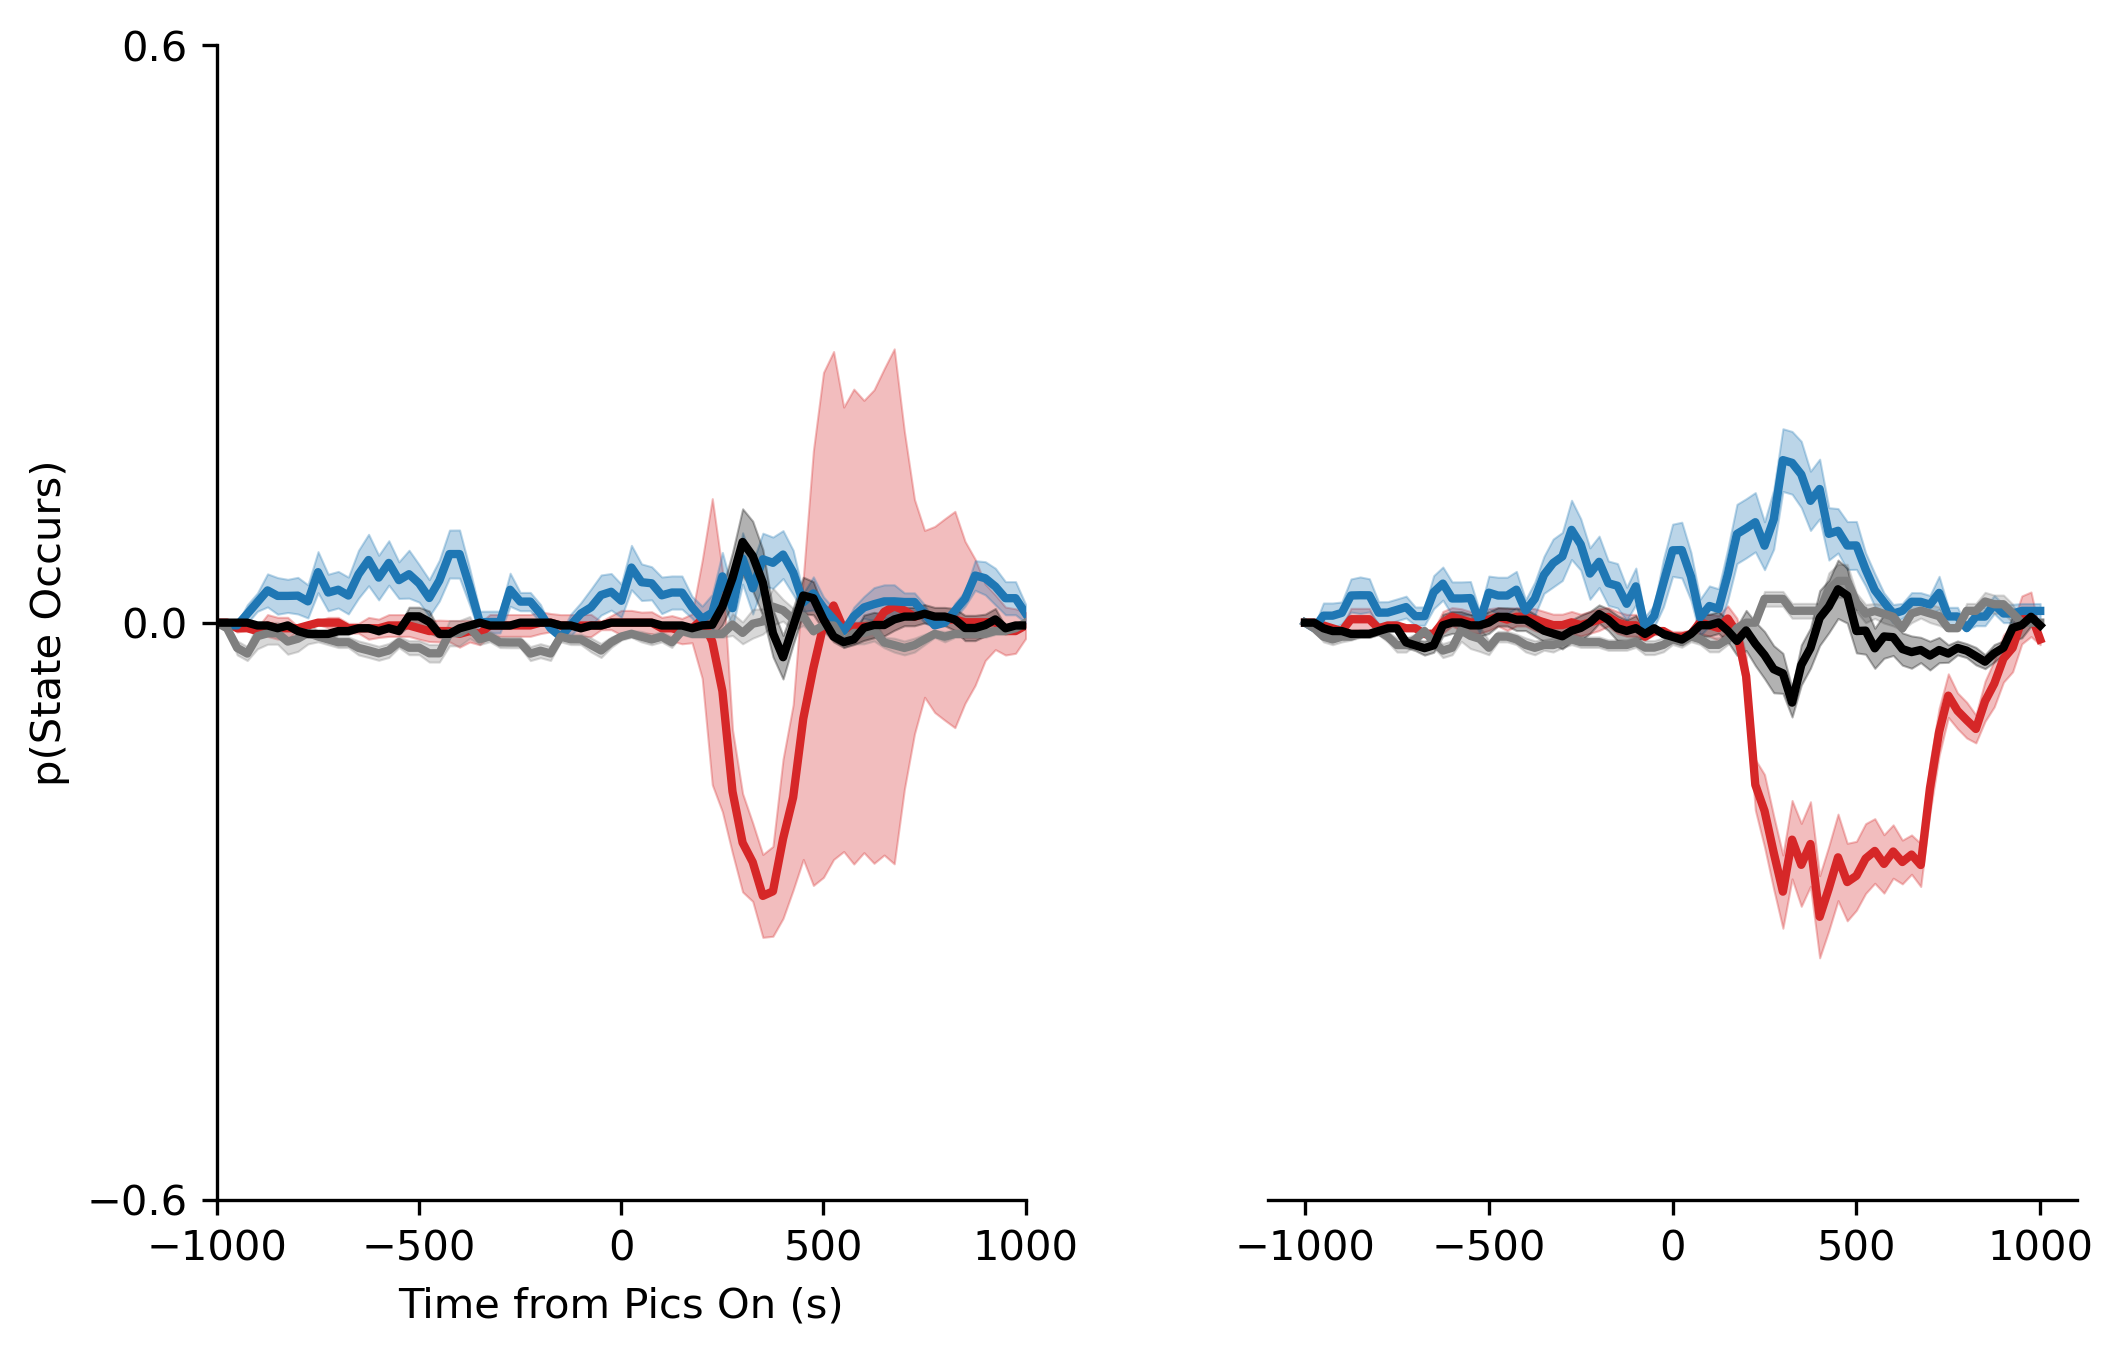

In [10]:
# plot mean and CI for differences between single and double saccades 
fig, ax = plt.subplots(1, 2, figsize=(8, 5), dpi=300)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase the width and height spaces between subplots
lw = 2
ofc_ylim=(0, .9)
cdn_ylim=(0, .75)
xlim=(-1000, 1000)
a_level = .3
error_lw = .5

ax[0].plot(ts, np.mean(OFC_ch_diff, axis=0) , color='tab:red', linewidth=lw)
ax[0].fill_between(ts, np.mean(OFC_ch_diff, axis=0) -OFC_ch_diff_CI, np.mean(OFC_ch_diff, axis=0) +OFC_ch_diff_CI, color='tab:red', alpha=a_level, linewidth=error_lw)
ax[0].plot(ts, np.mean(OFC_unch_diff, axis=0), color='tab:blue', linewidth=lw)
ax[0].fill_between(ts, np.mean(OFC_unch_diff, axis=0)-OFC_unch_diff_CI, np.mean(OFC_unch_diff, axis=0)+OFC_unch_diff_CI, color='tab:blue', alpha=a_level, linewidth=error_lw)
ax[0].plot(ts, np.mean(OFC_alt_ch_diff, axis=0), color='tab:gray', linewidth=lw)
ax[0].fill_between(ts, np.mean(OFC_alt_ch_diff, axis=0)-OFC_alt_ch_diff_CI, np.mean(OFC_alt_ch_diff, axis=0)+OFC_alt_ch_diff_CI, color='tab:gray', alpha=a_level, linewidth=error_lw)
ax[0].plot(ts, np.mean(OFC_alt_unch_diff, axis=0), color='black', linewidth=lw)
ax[0].fill_between(ts, np.mean(OFC_alt_unch_diff, axis=0)-OFC_alt_unch_diff_CI, np.mean(OFC_alt_unch_diff, axis=0)+OFC_alt_unch_diff_CI, color='black', alpha=a_level, linewidth=error_lw)
ax[0].set_xlim(xlim)
ax[0].set_yticks((-.6, 0, .6))
ax[0].set_xticks((-1000, -500, 0, 500, 1000))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', which='both', top=False, right=False)
ax[0].set_ylabel('p(State Occurs)')
ax[0].set_xlabel('Time from Pics On (s)')


ax[1].plot(ts, np.mean(CdN_ch_diff, axis=0) , color='tab:red', linewidth=lw)
ax[1].fill_between(ts, np.mean(CdN_ch_diff, axis=0) -CdN_ch_diff_CI, np.mean(CdN_ch_diff, axis=0) +CdN_ch_diff_CI, color='tab:red', alpha=a_level, linewidth=error_lw)
ax[1].plot(ts, np.mean(CdN_unch_diff, axis=0), color='tab:blue', linewidth=lw)
ax[1].fill_between(ts, np.mean(CdN_unch_diff, axis=0)-CdN_unch_diff_CI, np.mean(CdN_unch_diff, axis=0)+CdN_unch_diff_CI, color='tab:blue', alpha=a_level, linewidth=error_lw)
ax[1].plot(ts, np.mean(CdN_alt_ch_diff, axis=0), color='tab:gray', linewidth=lw)
ax[1].fill_between(ts, np.mean(CdN_alt_ch_diff, axis=0)-CdN_alt_ch_diff_CI, np.mean(CdN_alt_ch_diff, axis=0)+CdN_alt_ch_diff_CI, color='tab:gray', alpha=a_level, linewidth=error_lw)
ax[1].plot(ts, np.mean(CdN_alt_unch_diff, axis=0), color='black', linewidth=lw)
ax[1].fill_between(ts, np.mean(CdN_alt_unch_diff, axis=0)-CdN_alt_unch_diff_CI, np.mean(CdN_alt_unch_diff, axis=0)+CdN_alt_unch_diff_CI, color='black', alpha=a_level, linewidth=error_lw)
ax[1].set_ylim((-.6,.6))
ax[1].set_xticks((-1000, -500, 0, 500, 1000))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)


#fig.savefig('OFC_CDN_doubletake_difference_decoding.svg', format='svg')

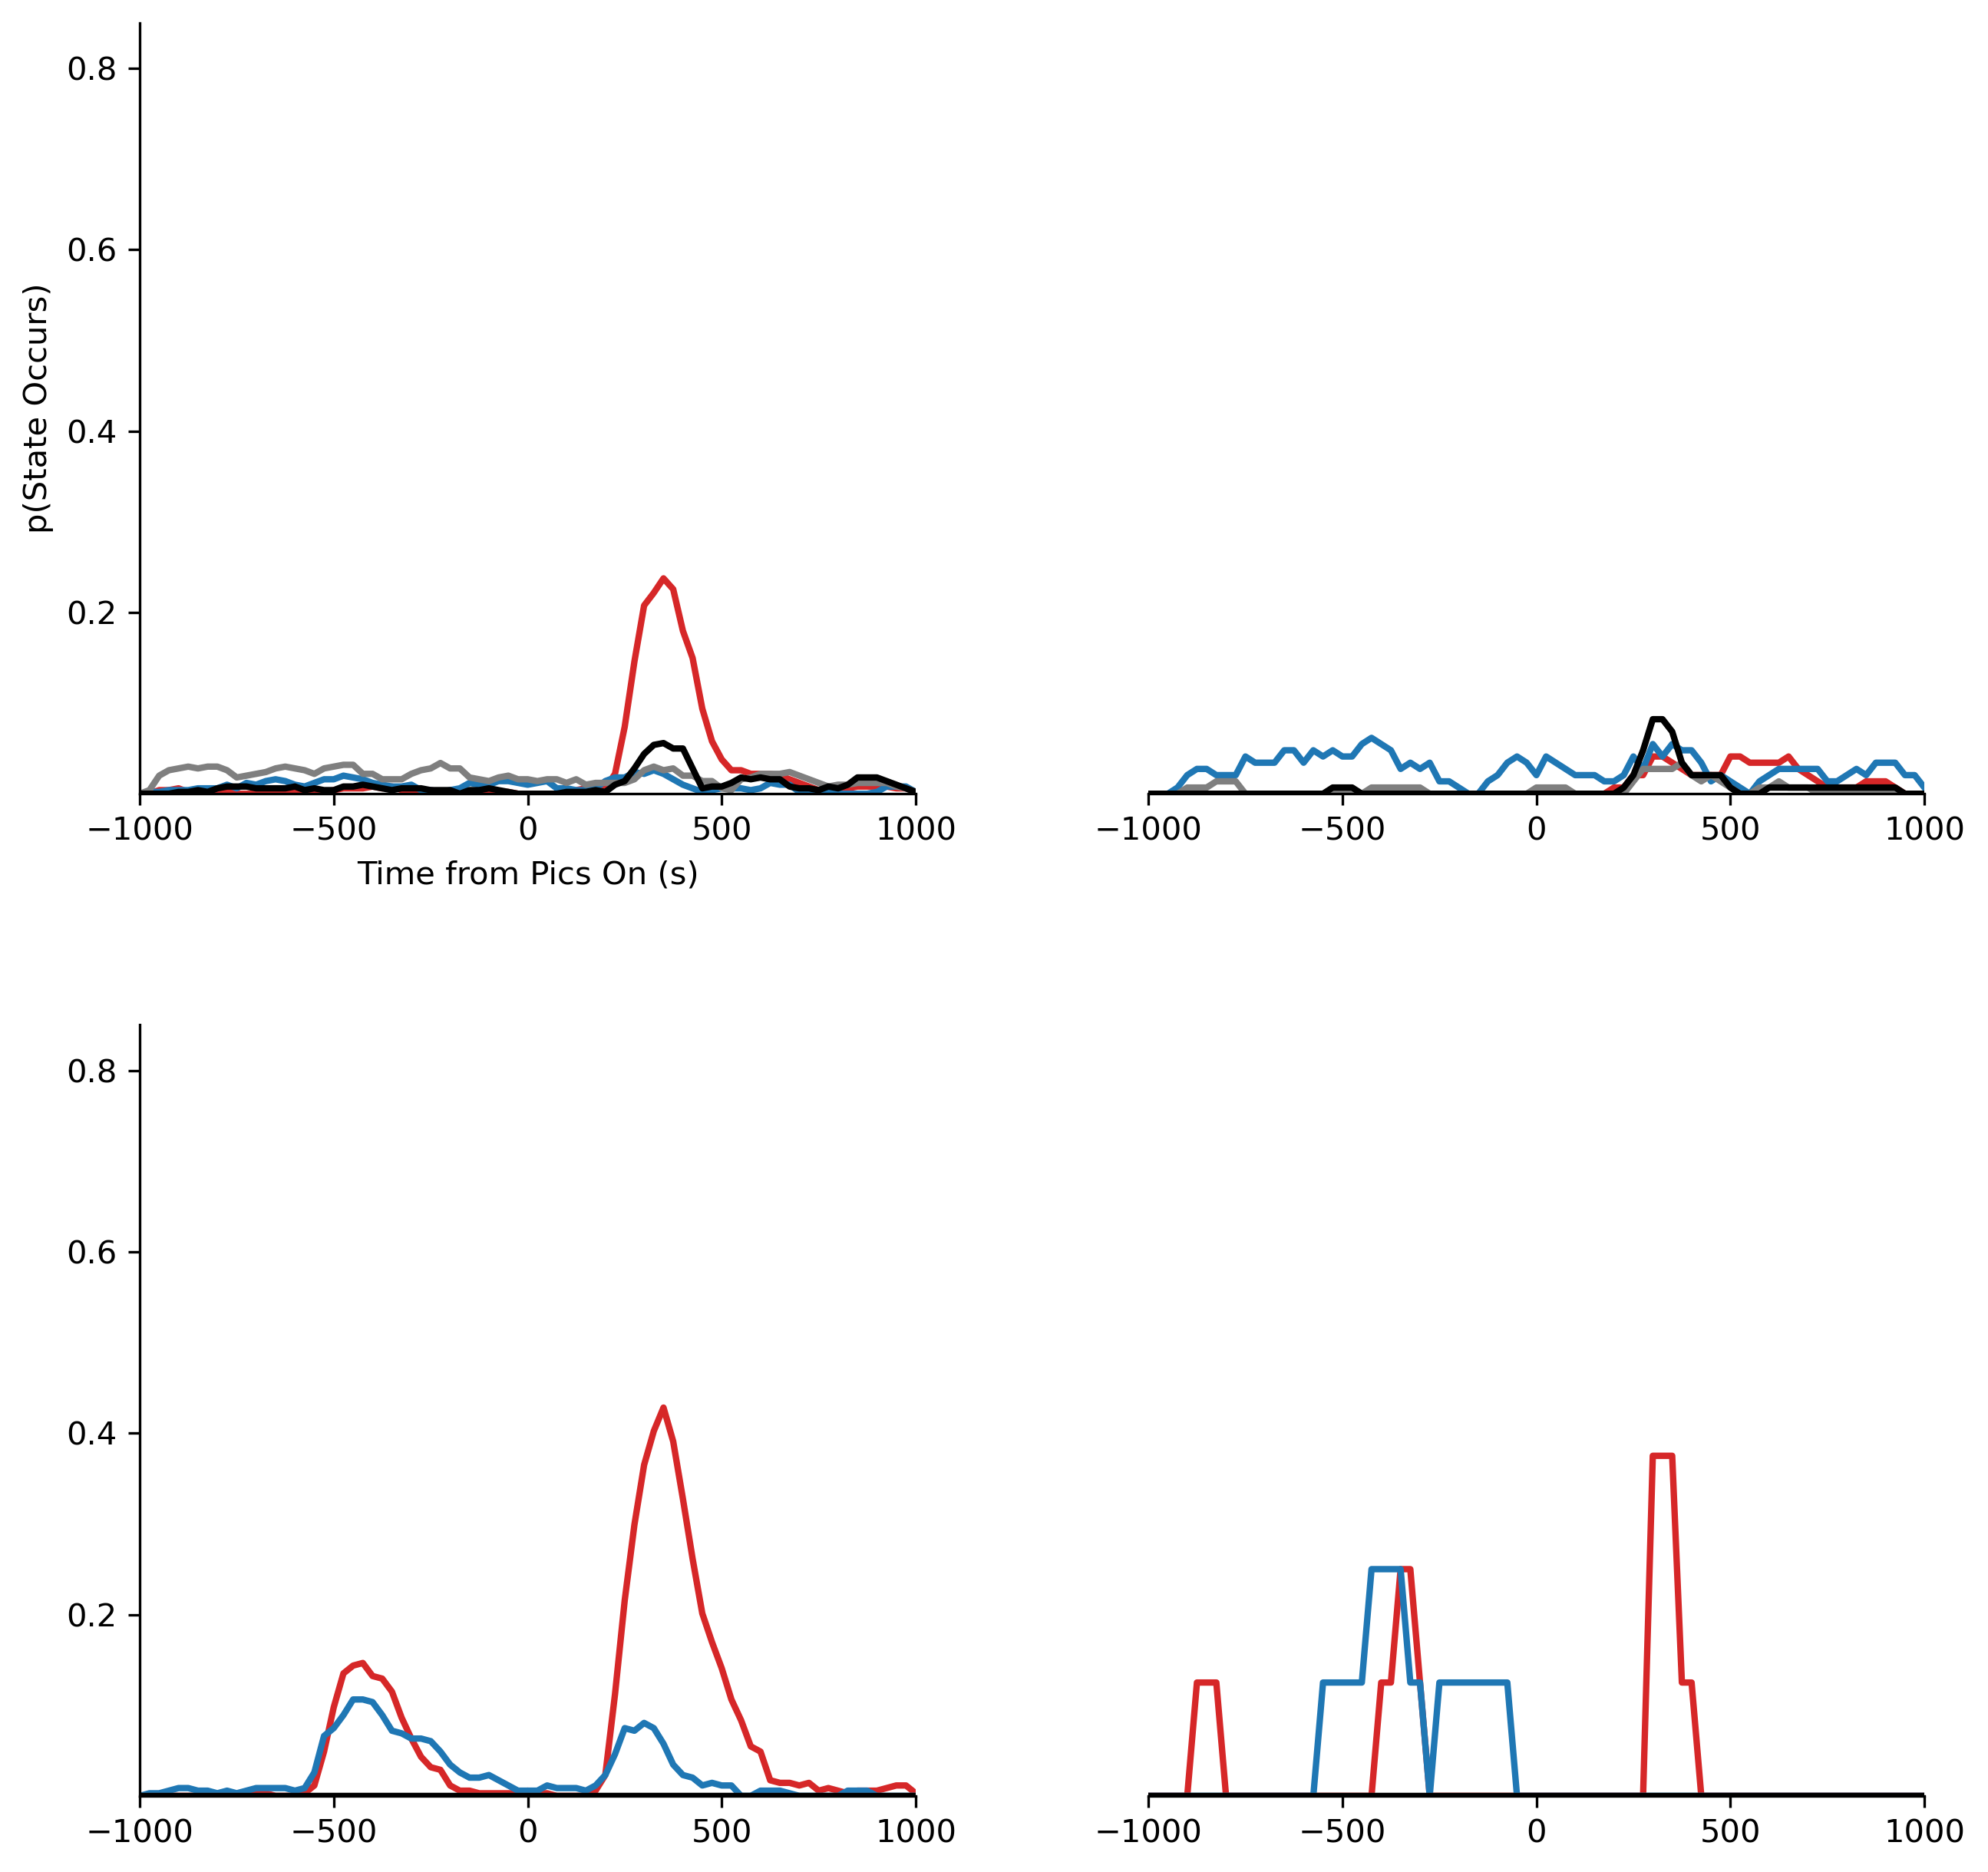

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=300)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase the width and height spaces between subplots
lw = 2
ylim=(0, .85)
xlim=(-1000, 1000)

ax[0,0].plot(ts, np.nanmean(OFC_ch_states[ix1 & s12_ix, :], axis=0), color='tab:red', linewidth=lw)
ax[0,0].plot(ts, np.nanmean(OFC_unch_states[ix1 & s12_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax[0,0].plot(ts, np.nanmean(OFC_alt_ch_states[ix1 & s12_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax[0,0].plot(ts, np.nanmean(OFC_alt_unch_states[ix1 & s12_ix, :], axis=0), color='black', linewidth=lw)
ax[0,0].set_ylim(ylim)
ax[0,0].set_xlim(xlim)
ax[0,0].set_yticks((.2, .4, .6, .8))
ax[0,0].set_xticks((-1000, -500, 0, 500, 1000))
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].tick_params(axis='both', which='both', top=False, right=False)
ax[0,0].set_ylabel('p(State Occurs)')
ax[0,0].set_xlabel('Time from Pics On (s)')


ax[0,1].plot(ts, np.nanmean(OFC_ch_states[ix2 & s12_ix, :], axis=0), color='tab:red', linewidth=lw)
ax[0,1].plot(ts, np.nanmean(OFC_unch_states[ix2 & s12_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax[0,1].plot(ts, np.nanmean(OFC_alt_ch_states[ix2 & s12_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax[0,1].plot(ts, np.nanmean(OFC_alt_unch_states[ix2 & s12_ix, :], axis=0), color='black', linewidth=lw)
ax[0,1].set_ylim(ylim)
ax[0,1].set_xlim(xlim)
ax[0,1].set_yticks((.2, .4, .6, .8))
ax[0,1].set_xticks((-1000, -500, 0, 500, 1000))
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)



ax[1,0].plot(ts, np.nanmean(OFC_ch_states[ix1 & s3_ix, :], axis=0), color='tab:red', linewidth=lw)
ax[1,0].plot(ts, np.nanmean(OFC_unch_states[ix1 & s3_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax[1,0].plot(ts, np.nanmean(OFC_alt_ch_states[ix1 & s3_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax[1,0].plot(ts, np.nanmean(OFC_alt_unch_states[ix1 & s3_ix, :], axis=0), color='black', linewidth=lw)
ax[1,0].set_ylim(ylim)
ax[1,0].set_xlim(xlim)
ax[1,0].set_yticks((.2, .4, .6, .8))
ax[1,0].set_xticks((-1000, -500, 0, 500, 1000))
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].tick_params(axis='both', which='both', top=False, right=False)


ax[1,1].plot(ts, np.nanmean(OFC_ch_states[ix2 & s3_ix, :], axis=0), color='tab:red', linewidth=lw)
ax[1,1].plot(ts, np.nanmean(OFC_unch_states[ix2 & s3_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax[1,1].plot(ts, np.nanmean(OFC_alt_ch_states[ix2 & s3_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax[1,1].plot(ts, np.nanmean(OFC_alt_unch_states[ix2 & s3_ix, :], axis=0), color='black', linewidth=lw)
ax[1,1].set_ylim(ylim)
ax[1,1].set_xlim(xlim)
ax[1,1].set_yticks((.2, .4, .6, .8))
ax[1,1].set_xticks((-1000, -500, 0, 500, 1000))
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)


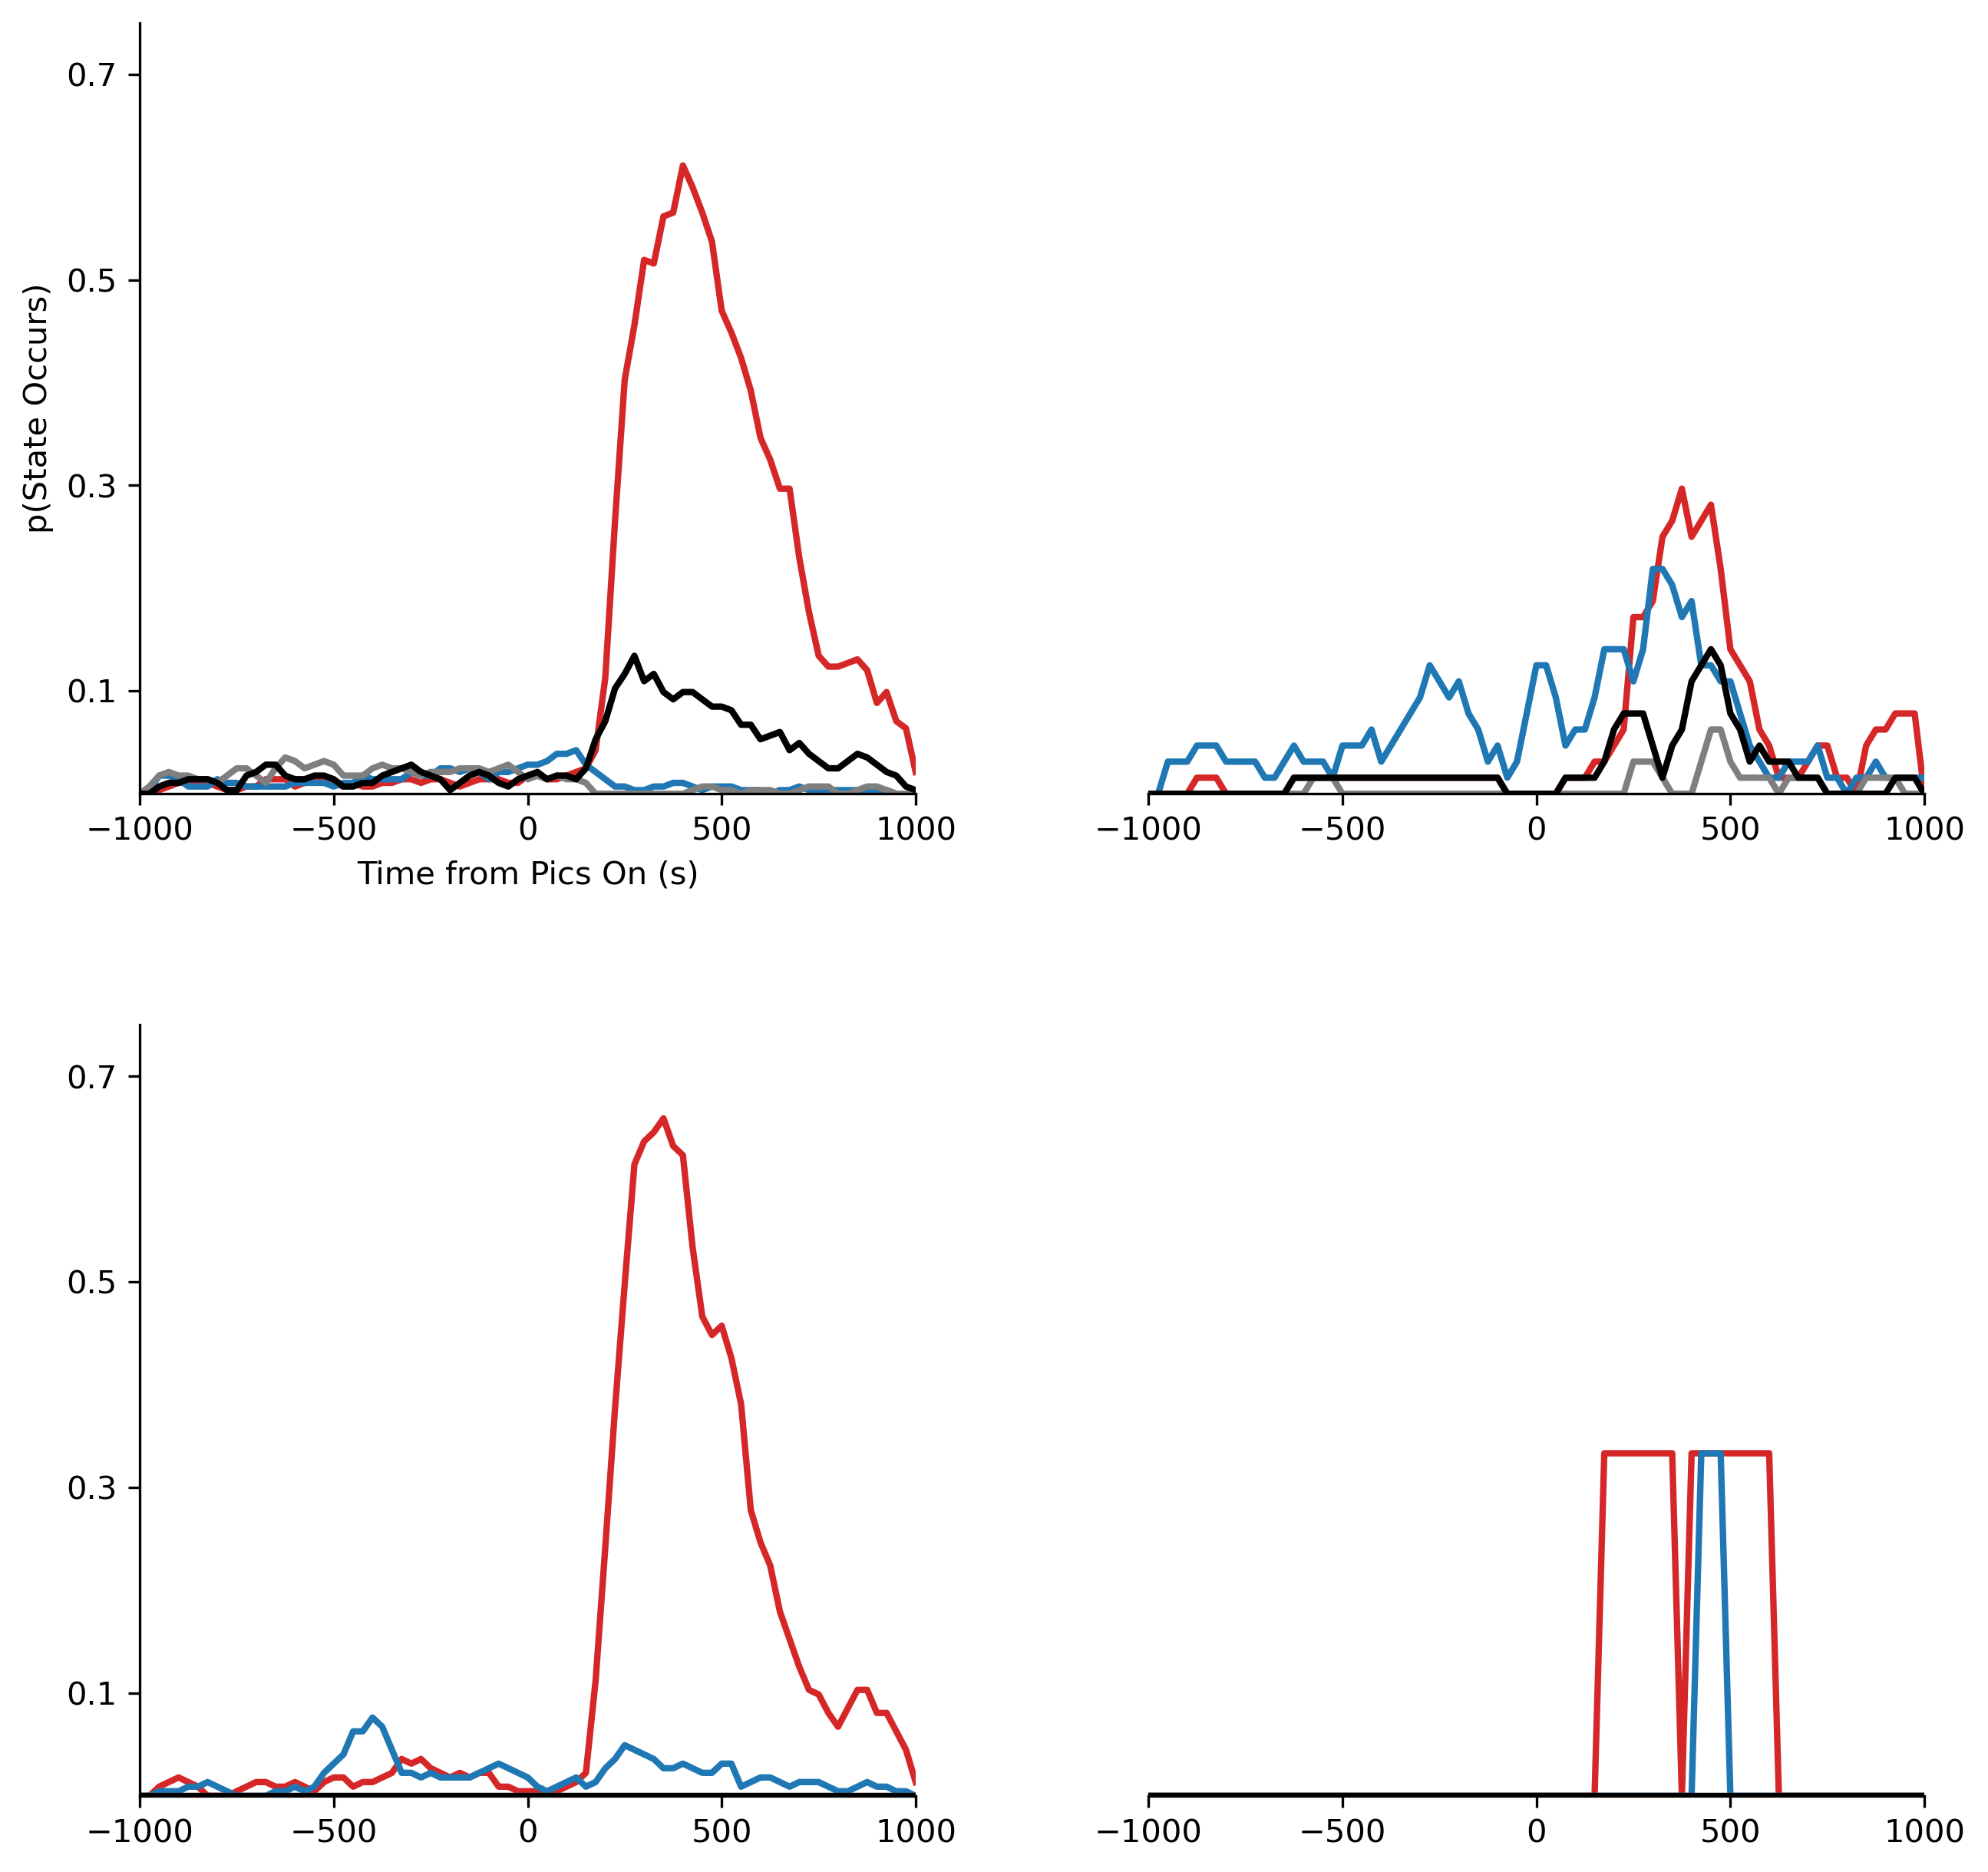

In [12]:
fig2, ax2 = plt.subplots(2, 2, figsize=(10, 10), dpi=300)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase the width and height spaces between subplots
lw = 2
ylim2=(0, .75)
yticks = (.1, .3, .5, .7)
xlim=(-1000, 1000)

ax2[0,0].plot(ts, np.nanmean(CdN_ch_states[ix1 & s12_ix & CdN_ix,:], axis=0), color='tab:red', linewidth=lw)
ax2[0,0].plot(ts, np.nanmean(CdN_unch_states[ix1 & s12_ix & CdN_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax2[0,0].plot(ts, np.nanmean(CdN_alt_ch_states[ix1 & s12_ix & CdN_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax2[0,0].plot(ts, np.nanmean(CdN_alt_unch_states[ix1 & s12_ix & CdN_ix, :], axis=0), color='black', linewidth=lw)
ax2[0,0].set_ylim(ylim2)
ax2[0,0].set_xlim(xlim)
ax2[0,0].set_yticks(yticks)
ax2[0,0].set_xticks((-1000, -500, 0, 500, 1000))
ax2[0,0].spines['top'].set_visible(False)
ax2[0,0].spines['right'].set_visible(False)
ax2[0,0].tick_params(axis='both', which='both', top=False, right=False)
ax2[0,0].set_ylabel('p(State Occurs)')
ax2[0,0].set_xlabel('Time from Pics On (s)')


ax2[0,1].plot(ts, np.nanmean(CdN_ch_states[ix2 & s12_ix & CdN_ix, :], axis=0), color='tab:red', linewidth=lw)
ax2[0,1].plot(ts, np.nanmean(CdN_unch_states[ix2 & s12_ix & CdN_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax2[0,1].plot(ts, np.nanmean(CdN_alt_ch_states[ix2 & s12_ix & CdN_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax2[0,1].plot(ts, np.nanmean(CdN_alt_unch_states[ix2 & s12_ix & CdN_ix, :], axis=0), color='black', linewidth=lw)
ax2[0,1].set_ylim(ylim2)
ax2[0,1].set_xlim(xlim)
ax2[0,1].set_yticks(yticks)
ax2[0,1].set_xticks((-1000, -500, 0, 500, 1000))
ax2[0,1].spines['top'].set_visible(False)
ax2[0,1].spines['right'].set_visible(False)
ax2[0,1].spines['left'].set_visible(False)
ax2[0,1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)



ax2[1,0].plot(ts, np.nanmean(CdN_ch_states[ix1 & s3_ix & CdN_ix, :], axis=0), color='tab:red', linewidth=lw)
ax2[1,0].plot(ts, np.nanmean(CdN_unch_states[ix1 & s3_ix & CdN_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax2[1,0].plot(ts, np.nanmean(CdN_alt_ch_states[ix1 & s3_ix & CdN_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax2[1,0].plot(ts, np.nanmean(CdN_alt_unch_states[ix1 & s3_ix & CdN_ix, :], axis=0), color='black', linewidth=lw)
ax2[1,0].set_ylim(ylim2)
ax2[1,0].set_xlim(xlim)
ax2[1,0].set_yticks(yticks)
ax2[1,0].set_xticks((-1000, -500, 0, 500, 1000))
ax2[1,0].spines['top'].set_visible(False)
ax2[1,0].spines['right'].set_visible(False)
ax2[1,0].tick_params(axis='both', which='both', top=False, right=False)


ax2[1,1].plot(ts, np.nanmean(CdN_ch_states[ix2 & s3_ix & CdN_ix, :], axis=0), color='tab:red', linewidth=lw)
ax2[1,1].plot(ts, np.nanmean(CdN_unch_states[ix2 & s3_ix & CdN_ix, :], axis=0), color='tab:blue', linewidth=lw)
ax2[1,1].plot(ts, np.nanmean(CdN_alt_ch_states[ix2 & s3_ix & CdN_ix, :], axis=0), color='tab:gray', linewidth=lw)
ax2[1,1].plot(ts, np.nanmean(CdN_alt_unch_states[ix2 & s3_ix & CdN_ix, :], axis=0), color='black', linewidth=lw)
ax2[1,1].set_ylim(ylim2)
ax2[1,1].set_xlim(xlim)
ax2[1,1].set_yticks(yticks)
ax2[1,1].set_xticks((-1000, -500, 0, 500, 1000))
ax2[1,1].spines['top'].set_visible(False)
ax2[1,1].spines['right'].set_visible(False)
ax2[1,1].spines['left'].set_visible(False)
ax2[1,1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)

In [13]:
# find when "impulsive states" occurred in both areas
impulsive_states = (np.sum(CdN_alt_unch_states[:, 41:60], axis=1) > 0) 
print('found ', np.sum(impulsive_states), '"impulsive" states')

OFC_impulsive_mean, OFC_impulsive_sem = calculate_mean_and_interval(OFC_alt_unch_states[ix2 & s12_ix & impulsive_states, :],'bootstrap')
CdN_impulsive_mean, CdN_impulsive_sem = calculate_mean_and_interval(CdN_alt_unch_states[ix2 & s12_ix & impulsive_states, :],'bootstrap')



found  95 "impulsive" states


Text(0.5, 0, 'Time from Pics On (s)')

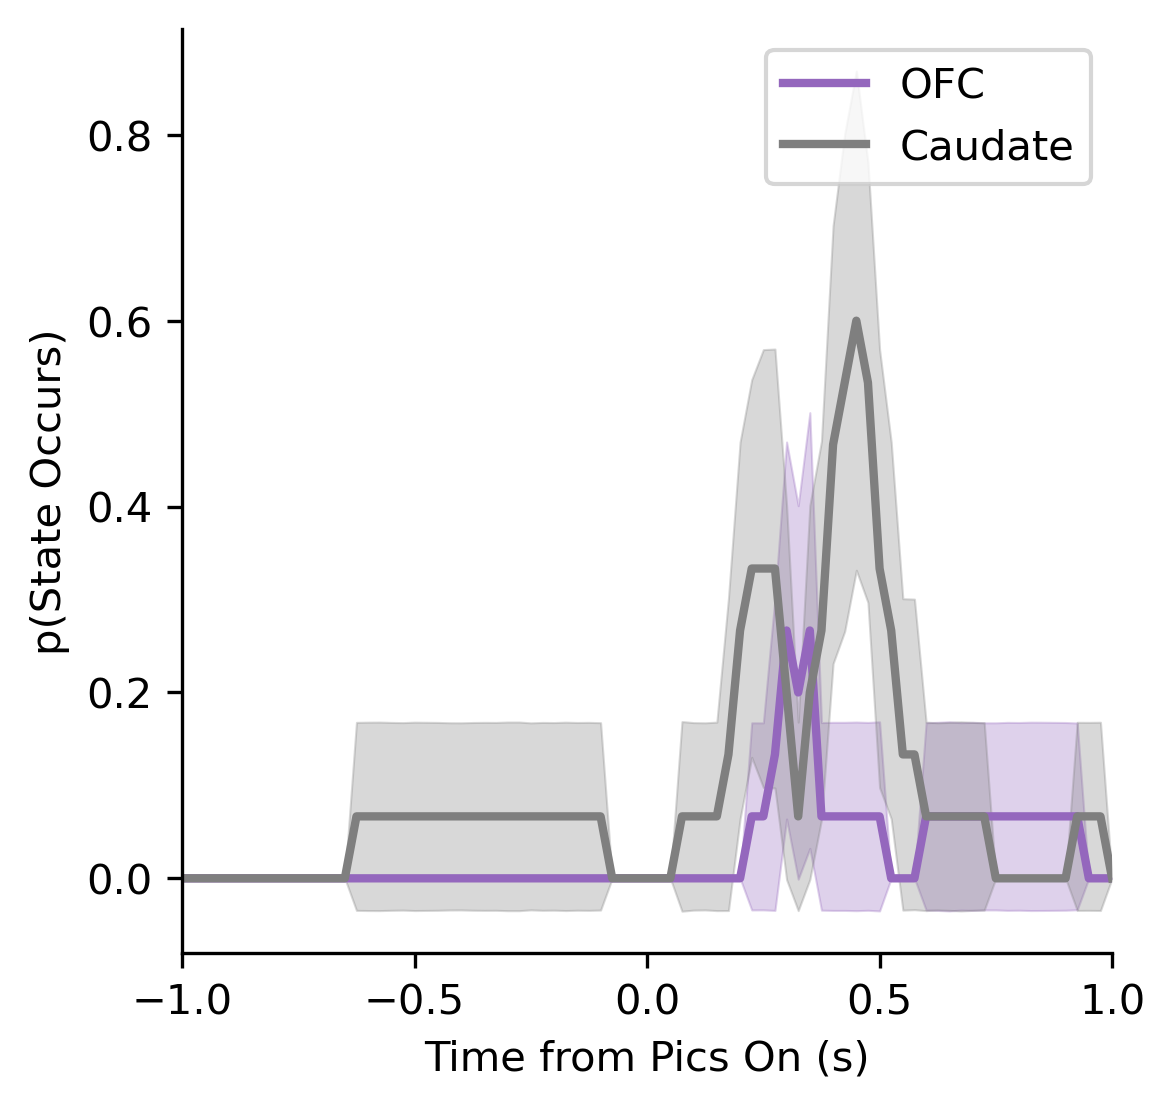

In [14]:
# Create a figure and two subplots
fig3, ax3 = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

new_ts = ts/1000

ax3.plot(new_ts, OFC_impulsive_mean, color='tab:purple', linewidth=lw, label='OFC')
ax3.fill_between(new_ts, OFC_impulsive_mean-OFC_impulsive_sem, OFC_impulsive_mean+OFC_impulsive_sem, color='tab:purple', alpha=a_level, linewidth=error_lw)
ax3.plot(new_ts, CdN_impulsive_mean, color='tab:gray', linewidth=lw, label='Caudate')
ax3.fill_between(new_ts, CdN_impulsive_mean-CdN_impulsive_sem, CdN_impulsive_mean+CdN_impulsive_sem, color='tab:gray', alpha=a_level, linewidth=error_lw)
ax3.set_xlim(-1,1)
ax3.set_xticks((-1, -.5, 0, .5, 1))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.tick_params(axis='both', which='both', top=False, right=False)
ax3.legend()
ax3.set_ylabel('p(State Occurs)')
ax3.set_xlabel('Time from Pics On (s)')

Text(0.5, 1.0, 'State C')

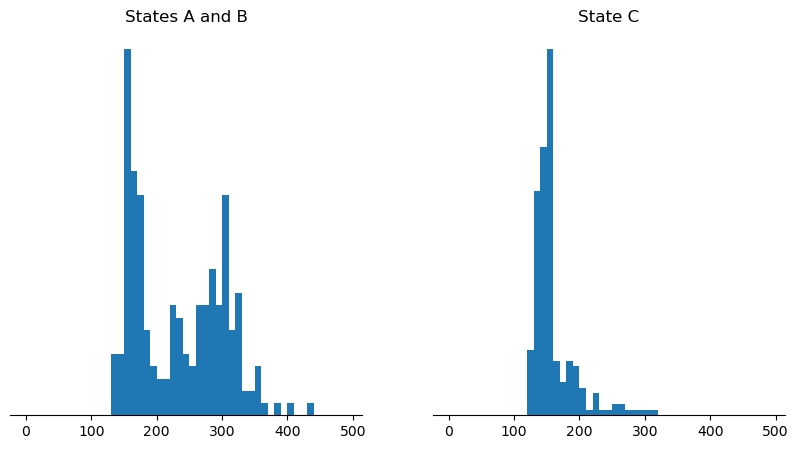

In [15]:
# plot RTs

hist_bins = np.arange(0, 500, 10)

valid_trials = bhv['forced'] == 0

# Create a figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(bhv['rt'].loc[valid_trials & (bhv['state'] == 2)], bins=hist_bins, density=True)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='both', which='both', top=False, left=False, right=False, labelleft=False)  
ax[0].set_title('States A and B')

ax[1].hist(bhv['rt'].loc[valid_trials & (bhv['state'] == 3)], bins=hist_bins, density=True)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].tick_params(axis='both', which='both', top=False, left=False, right=False, labelleft=False)  
ax[1].set_title('State C')

#fig.savefig('self_control_RT_plot.svg', format='svg')


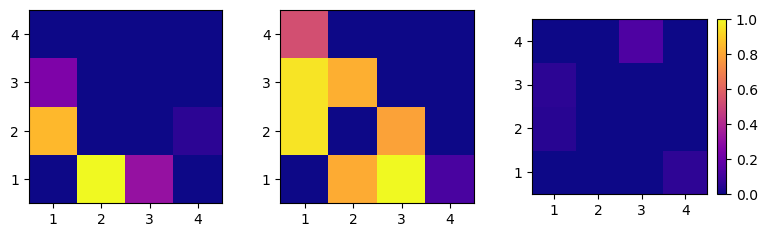

In [16]:
valid_trials = (bhv['n_sacc'] < 3) & (bhv['forced'] == 0)
valid_bhv = bhv.loc[valid_trials]

double_takes = valid_bhv['n_sacc'] == 2

first_sacc_val = valid_bhv['sacc1_val'].loc[double_takes].mean()

vals = np.arange(1,5,1)

# initialize some arrays for accumulating p(double takes) into
state_a_dt = np.zeros(shape=(4,4))
state_b_dt = np.zeros(shape=(4,4))
state_c_dt = np.zeros(shape=(4,4))

p_double_mean = np.empty(shape=(4, ))
p_double_sem = np.empty(shape=(4, ))

for r_ix, r_val in enumerate(vals):
    
    for l_ix, l_val in enumerate(vals):
        
        # be sure not to look for instances where the values were the same (they don't exist!)
        if l_val != r_val:
            
            cond_ix = (valid_bhv['r_val'] == r_val) &  (valid_bhv['l_val'] == l_val)
            
            # get likelihood of a double take for this condition in each task state
            state_a_dt[r_ix, l_ix] = np.mean(double_takes[cond_ix & (valid_bhv['state'] == 1)])
            state_b_dt[r_ix, l_ix] = np.mean(double_takes[cond_ix & (valid_bhv['state'] == 2)])
            state_c_dt[r_ix, l_ix] = np.mean(double_takes[cond_ix & (valid_bhv['state'] == 3)])
            
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase the width and height spaces between subplots

img = ax[0].pcolor(state_a_dt, vmin=0, vmax=1, cmap='plasma')
ax[0].set_xticks((.5,1.5,2.5,3.5))
ax[0].set_xticklabels((1,2,3,4))
ax[0].set_yticks((.5,1.5,2.5,3.5))
ax[0].set_yticklabels((1,2,3,4))
ax[0].set_aspect('equal')

ax[1].pcolor(state_b_dt, vmin=0, vmax=1, cmap='plasma')
ax[1].set_xticks((.5,1.5,2.5,3.5))
ax[1].set_xticklabels((1,2,3,4))
ax[1].set_yticks((.5,1.5,2.5,3.5))
ax[1].set_yticklabels((1,2,3,4))
ax[1].set_aspect('equal')


ax[2].pcolor(state_c_dt, vmin=0, vmax=1, cmap='plasma')
ax[2].set_xticks((.5,1.5,2.5,3.5))
ax[2].set_xticklabels((1,2,3,4))
ax[2].set_yticks((.5,1.5,2.5,3.5))
ax[2].set_yticklabels((1,2,3,4))
ax[2].set_aspect('equal')


# # Create a new set of axes for the colorbar
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(img, cax=cax)


#fig.savefig('double_takes_by_state_with_colorbar.svg', format='svg')


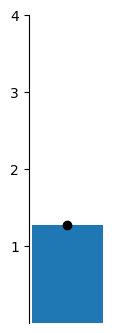

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(1, 4))
ax.bar(0, valid_bhv['sacc1_val'].loc[double_takes].mean())
ax.errorbar(0, valid_bhv['sacc1_val'].loc[double_takes].mean(), valid_bhv['sacc1_val'].loc[double_takes].sem(),
             color='black', marker='.', ms = 12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', which='both', top=False, right=False, bottom=False, labelbottom=False)

ax.set_ylim(0, 4)
ax.set_yticks((1,2,3,4))
#plt.savefig('first_sacc_val.svg', format='svg')

In [18]:
vals = np.arange(1,5,1)

p_choose_val = np.zeros(shape=(4, 3))

p_choose_val_sem = np.zeros(shape=(4, 3))

choose_v = []
val_var = []
state_var = []

for val_ix, val in enumerate(vals):
    
    val_in_trial = (valid_bhv['l_val'] == val) | (valid_bhv['r_val'] == val)
    ch_val = valid_bhv['ch_val'] == val
    
    p_choose_val[val_ix, 0] = np.mean(ch_val[val_in_trial & ((valid_bhv['state'] == 1))])
    p_choose_val[val_ix, 1] = np.mean(ch_val[val_in_trial & ((valid_bhv['state'] == 2))])
    p_choose_val[val_ix, 2] = np.mean(ch_val[val_in_trial & ((valid_bhv['state'] == 3))])
    
    p_choose_val_sem[val_ix, 0] = np.std(ch_val[val_in_trial & ((valid_bhv['state'] == 1))]) / np.sqrt(np.sum(val_in_trial & ((valid_bhv['state'] == 1))))
    p_choose_val_sem[val_ix, 1] = np.std(ch_val[val_in_trial & ((valid_bhv['state'] == 2))]) / np.sqrt(np.sum(val_in_trial & ((valid_bhv['state'] == 2))))
    p_choose_val_sem[val_ix, 2] = np.std(ch_val[val_in_trial & ((valid_bhv['state'] == 3))]) / np.sqrt(np.sum(val_in_trial & ((valid_bhv['state'] == 3))))
    
    # collect data for a regression
    choose_v.append(ch_val[val_in_trial & ((valid_bhv['state'] == 1))])
    choose_v.append(ch_val[val_in_trial & ((valid_bhv['state'] == 2))])
    choose_v.append(ch_val[val_in_trial & ((valid_bhv['state'] == 3))])
    
    val_var.append(np.ones_like(ch_val[val_in_trial & ((valid_bhv['state'] == 1))])*val)
    val_var.append(np.ones_like(ch_val[val_in_trial & ((valid_bhv['state'] == 2))])*val)
    val_var.append(np.ones_like(ch_val[val_in_trial & ((valid_bhv['state'] == 3))])*val)
    
    state_var.append(np.ones_like(ch_val[val_in_trial & ((valid_bhv['state'] == 1))])*1)
    state_var.append(np.ones_like(ch_val[val_in_trial & ((valid_bhv['state'] == 2))])*2)
    state_var.append(np.ones_like(ch_val[val_in_trial & ((valid_bhv['state'] == 3))])*3)




In [19]:
# put everything into a dataframe for logistic regression

# choose_v is a list of lists
choose_v_flat = np.concatenate(choose_v).astype(int)

reg_df = pd.DataFrame()
reg_df['choose_v'] = choose_v_flat
reg_df['state'] = np.concatenate(state_var)
reg_df['val'] = np.concatenate(val_var)

mdl = smf.logit(formula='choose_v ~ state*val', data=reg_df).fit()

print(mdl.summary())


Optimization terminated successfully.
         Current function value: 0.361300
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               choose_v   No. Observations:                 1276
Model:                          Logit   Df Residuals:                     1272
Method:                           MLE   Df Model:                            3
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                  0.4788
Time:                        21:52:37   Log-Likelihood:                -461.02
converged:                       True   LL-Null:                       -884.46
Covariance Type:            nonrobust   LLR p-value:                2.952e-183
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.1234      0.795     -7.701      0.000      -7.682      -4.565
state          0.3919      0.

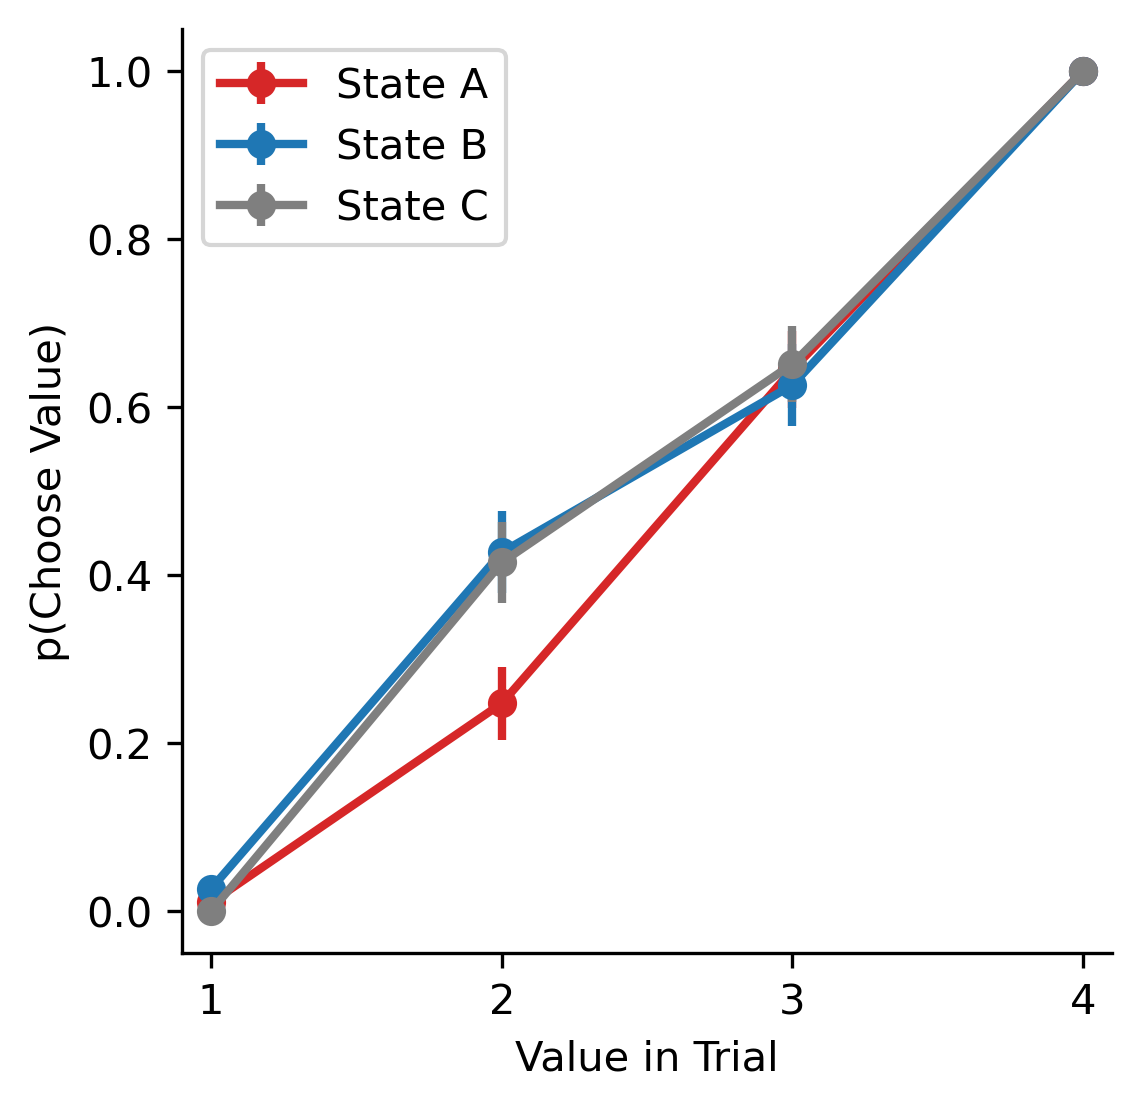

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

ax.errorbar(vals, p_choose_val[:,0], p_choose_val_sem[:,0], lw=2, marker='o', label='State A', color='tab:red')
ax.errorbar(vals, p_choose_val[:,1], p_choose_val_sem[:,1], lw=2, marker='o', label='State B', color='tab:blue')
ax.errorbar(vals, p_choose_val[:,2], p_choose_val_sem[:,2], lw=2, marker='o', label='State C', color='tab:gray')
ax.set_xlim(.9, 4.1)
ax.set_ylim(-.05, 1.05)
ax.set_xticks((1,2,3,4))
ax.set_xlabel('Value in Trial')
ax.set_ylabel('p(Choose Value)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
#fig.savefig('p_choose_val.svg', format='svg')    


In [21]:
# look at state frequencies during the choice period of each trial

# find the states associated with every trial
all_ofc_states = np.zeros_like(OFC_pps)
all_cdn_states = np.zeros_like(CdN_pps)


# loop over each decoder class
for j in range(OFC_pps.shape[2]):
    
    ofc_class_pps = OFC_pps[:,:, j]
    cdn_class_pps = CdN_pps[:,:, j]
        
    _, all_ofc_states[:,:,j] = find_candidate_states(ofc_class_pps, 12, 2)
    _, all_cdn_states[:,:,j] = find_candidate_states(cdn_class_pps, 12, 2)


# get indices of the 500ms from pics on
pics_on_ix = np.argwhere(ts == 0)[0][0]
pics_off_ix = np.argwhere(ts == 500)[0][0]

# grab the states during the choice
choice_ofc_states = all_ofc_states[:,pics_on_ix:pics_off_ix,:]
choice_cdn_states = all_cdn_states[:,pics_on_ix:pics_off_ix,:]

# find the number of states for each trial
ofc_n_states = np.sum(np.diff(choice_ofc_states, axis=1) > 0, axis=1)
cdn_n_states = np.sum(np.diff(choice_cdn_states, axis=1) > 0, axis=1)



ofc_n_states = ofc_n_states[valid_trials ]
cdn_n_states = cdn_n_states[valid_trials ]

(array([242.,   0., 267.,   0.,   0., 105.,   0.,  20.,   0.,   4.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

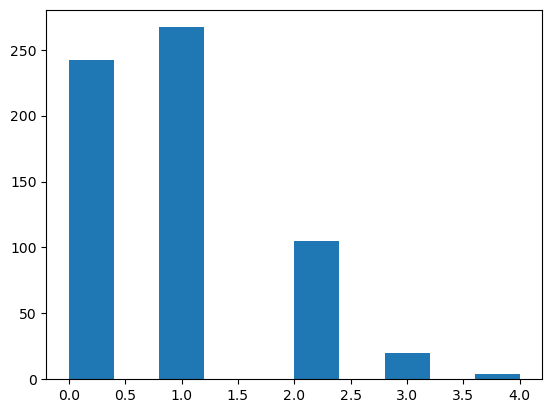

In [22]:
plt.hist(np.sum(ofc_n_states, axis=1))

In [23]:
# count the number of high, low, and unavaible states associated with each context on each trial
state = np.array([1,1,1,1,2,2,2,2,3,3,3,3])
value = np.array([1,2,3,4,1,2,3,4,1,2,3,4])

t_states = (valid_bhv['state'].values).astype(int)
t_n_states = np.zeros(shape=(valid_bhv.shape[0], 9)) # num of high, low, and NA states for each context on each trial

t_n_states[:] = np.nan

for t in range(valid_bhv.shape[0]):
    
    t_state = t_states[t]
    
    if np.sum(cdn_n_states[t, state == t_state]) > 0:
    
        if valid_bhv['l_val'].iloc[t] > valid_bhv['r_val'].iloc[t]:
            h_val = int(valid_bhv['l_val'].iloc[t])
            l_val = int(valid_bhv['r_val'].iloc[t])
        else:
            h_val = int(valid_bhv['r_val'].iloc[t])
            l_val = int(valid_bhv['l_val'].iloc[t])
            
        # find the corresponding high and low value states for each context
        c1_hv_ix = np.argwhere((state == 1) & (value == h_val))[0][0]
        c1_lv_ix = np.argwhere((state == 1) & (value == l_val))[0][0]
        c1_na_ix = np.argwhere((state == 1) & (value != l_val) & (value != h_val)).flatten()
        
        c2_hv_ix = np.argwhere((state == 2) & (value == h_val))[0][0]
        c2_lv_ix = np.argwhere((state == 2) & (value == l_val))[0][0]
        c2_na_ix = np.argwhere((state == 2) & (value != l_val) & (value != h_val)).flatten()
        
        c3_hv_ix = np.argwhere((state == 3) & (value == h_val))[0][0]
        c3_lv_ix = np.argwhere((state == 3) & (value == l_val))[0][0]
        c3_na_ix = np.argwhere((state == 3) & (value != l_val) & (value != h_val)).flatten()
        
        t_n_states[t,0] = cdn_n_states[t, c1_hv_ix]
        t_n_states[t,1] = cdn_n_states[t, c1_lv_ix]
        t_n_states[t,2] = (cdn_n_states[t, c1_na_ix[0]] + cdn_n_states[t, c1_na_ix[1]])/2
        
        t_n_states[t,3] = ofc_n_states[t, c2_hv_ix]
        t_n_states[t,4] = ofc_n_states[t, c2_lv_ix]
        t_n_states[t,5] = (ofc_n_states[t, c2_na_ix[0]] + cdn_n_states[t, c2_na_ix[1]])/2
        
        t_n_states[t,6] = cdn_n_states[t, c3_hv_ix]
        t_n_states[t,7] = cdn_n_states[t, c3_lv_ix]
        t_n_states[t,8] = (cdn_n_states[t, c3_na_ix[0]] + cdn_n_states[t, c3_na_ix[1]])/2

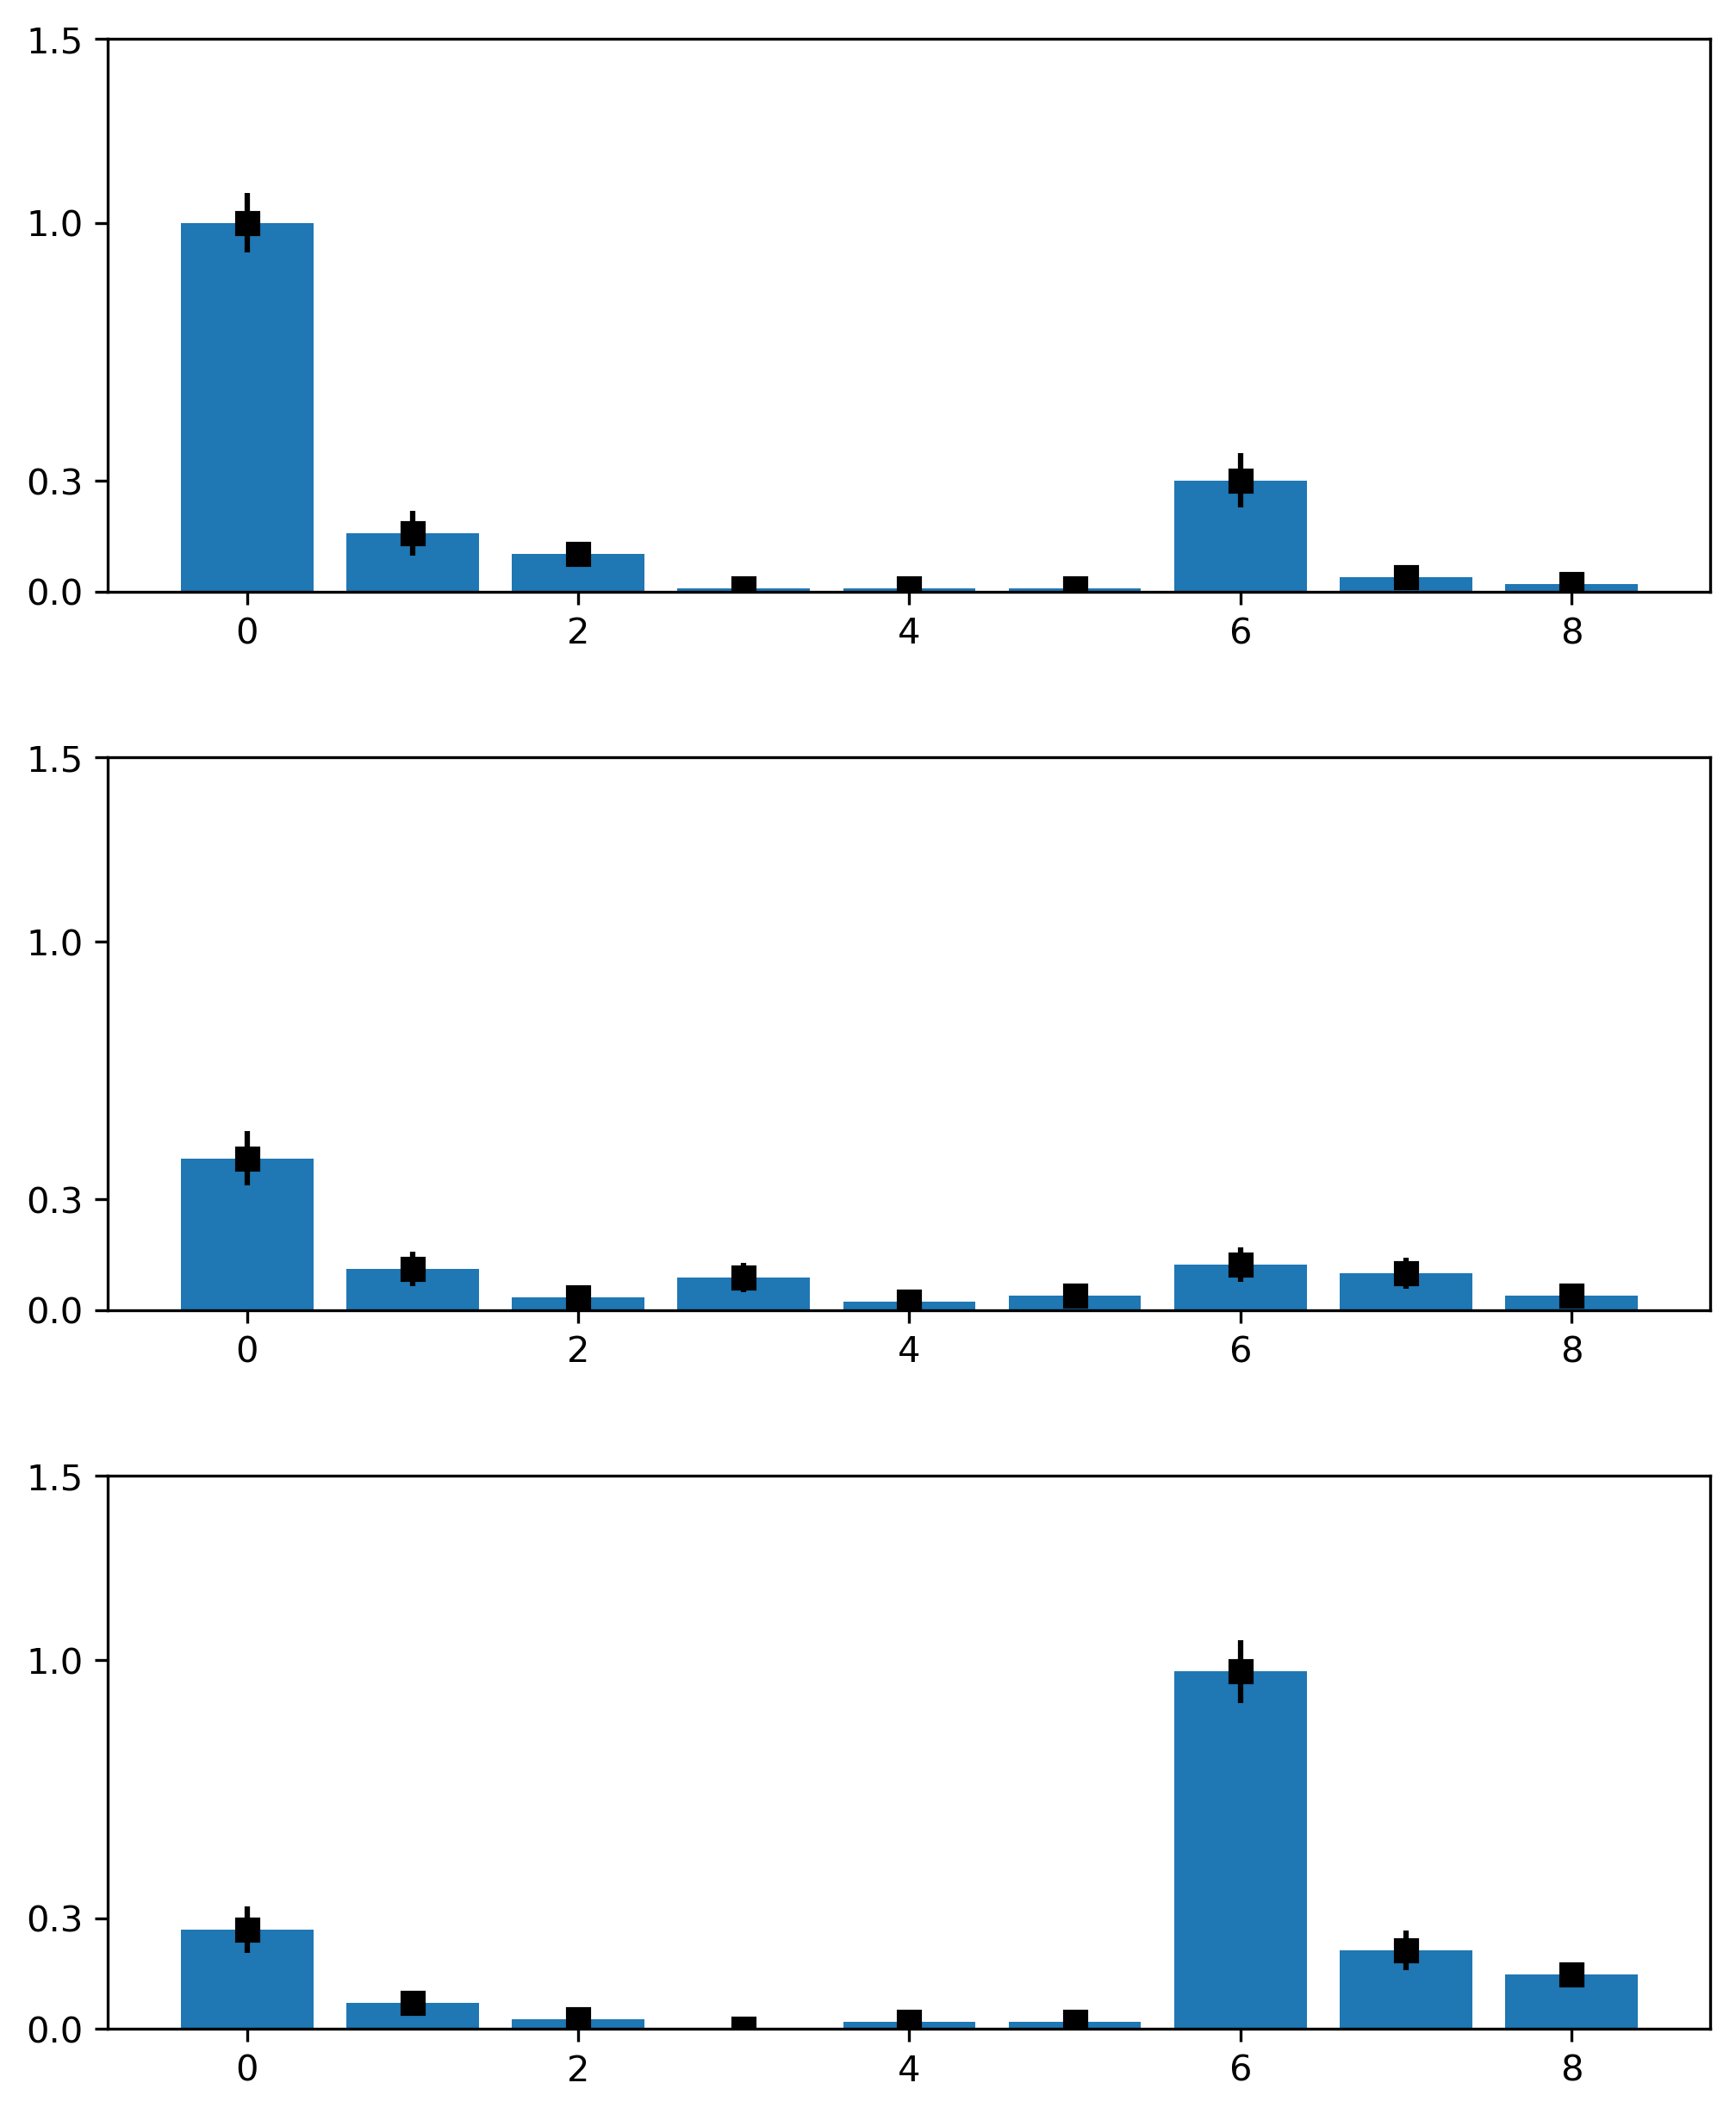

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase the width and height spaces between subplots

x = np.arange(9)

for s in range(3):
    
    s_mean, s_ci = calculate_mean_and_interval(t_n_states[t_states == s+1,:], 'bootstrap')
    
    ax[s].bar(x, s_mean)
    ax[s].errorbar(x, s_mean, s_ci, marker='s', linestyle='none', color='black')
    ax[s].set_ylim((0, .9))
    ax[s].set_yticks((0, .3, 1, 1.5))

#fig.savefig('n_CdN_states_by_cond.svg', format='svg')  

